# Importing Data

In [47]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()


from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [48]:
df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")

In [49]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

# Functions

In [50]:
@njit
#sums awkward array of 4-vectors, such that only one vector per event remains
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [51]:
#generates sum of two jets with same provenance
def generate_summed(jets, partons, prov):
    jets_prov = jets[jets.prov == prov]
    jets_2prov = jets_prov[ak.num(jets_prov.pt, axis=1) == 2]
    summed_jets_prov = jets_2prov[:,0] + jets_2prov[:,1]
    
    partons_prov = partons[jets.prov == prov]
    partons_2prov = partons_prov[ak.num(partons_prov.pt, axis=1) == 2]
    summed_partons_prov = partons_2prov[:,0] + partons_2prov[:,1]
    return summed_jets_prov, summed_partons_prov

#selects events which include a given provenance (particle) with a certain multiplicity.
#provs: array of provenances;   mults: corresponding multiplicities
def select_include(jets, partons, provs, mults):
    new_jets = jets
    new_partons = partons
    for (prov, mult) in zip(provs, mults):
        if mult == -1:
            mask = (ak.sum(new_jets.prov == prov, axis=1) != 0)
            new_jets = new_jets[mask]
            new_partons = new_partons[mask]
        else:
            mask = (ak.sum(new_jets.prov == prov, axis=1) == mult)
            new_jets = new_jets[mask]
            new_partons = new_partons[mask]
    return new_jets, new_partons

#selects only those jets/partons of a given provenance (particle)
def select_only(jets, partons, prov):
    new_jets = jets[jets.prov == prov]
    new_partons = partons[jets.prov == prov]
    return new_jets, new_partons

# Preparing Data

In [52]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

In [53]:
incoming_pz = 6500*(generator_info.x1 - generator_info.x2)
incoming_E = 6500*(generator_info.x1 + generator_info.x2)

incoming_boost = ak.Array(
    {"px": np.zeros_like(incoming_pz), "py": np.zeros_like(incoming_pz), "pz": incoming_pz, "E": incoming_E},
    with_name="Momentum4D"
)

In [54]:
parton_boost_nolepton = get_vector_sum(partons)
parton_boost_lepton = get_vector_sum(lepton_partons)
parton_boost = parton_boost_nolepton + parton_boost_lepton

# Exercise Plots

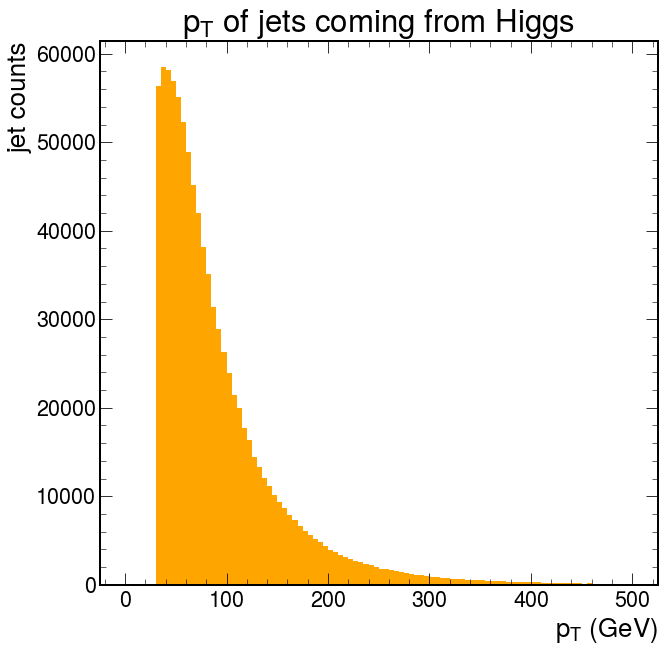

In [55]:
#find jets with provenance 1
prov1_jets = jets[jets.prov == 1]

#plot the transverse momenta of these jets
plt.hist(ak.flatten(prov1_jets.pt), bins=100, range=(0, 500), color="orange")
plt.title(r"$p_T$ of jets coming from Higgs")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("jet counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/pt_from_higgs.png")
plt.show()

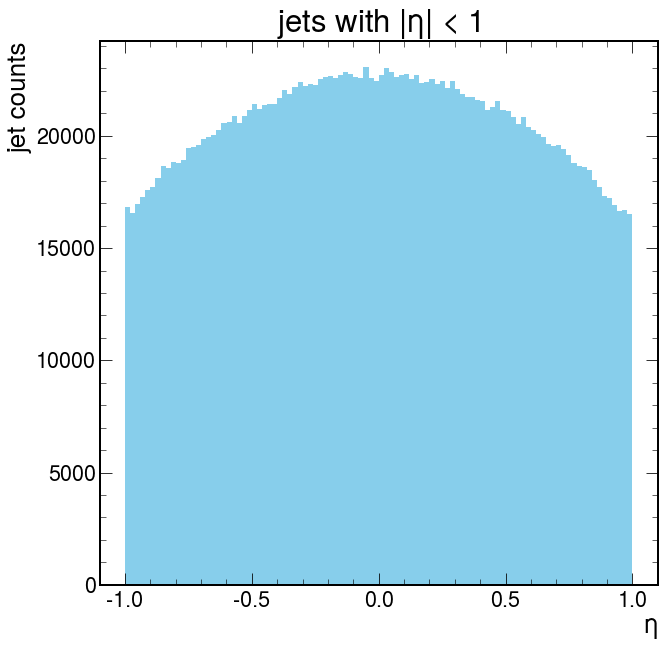

In [56]:
#find jets with |eta|<1
smalleta_jets = jets[np.abs(jets.eta) < 1.0]

#plot the eta of these jets
plt.hist(ak.flatten(smalleta_jets.eta), bins=100, color="skyblue")
plt.xlabel(r"$\eta$")
plt.ylabel("jet counts")
plt.title(r"jets with |$\eta$| < 1")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/small_eta_jets.png")
plt.show()

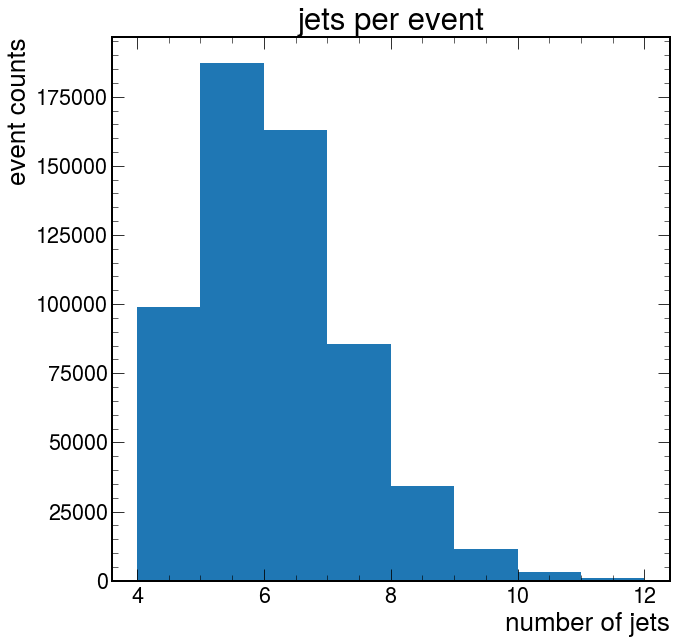

In [57]:
#count number of jets per event
jetnum = ak.num(jets.pt, axis=1)
plt.hist(jetnum, bins=8, range=(4,12))
plt.title("jets per event")
plt.xlabel("number of jets")
plt.ylabel("event counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/jets_per_event")
plt.show()

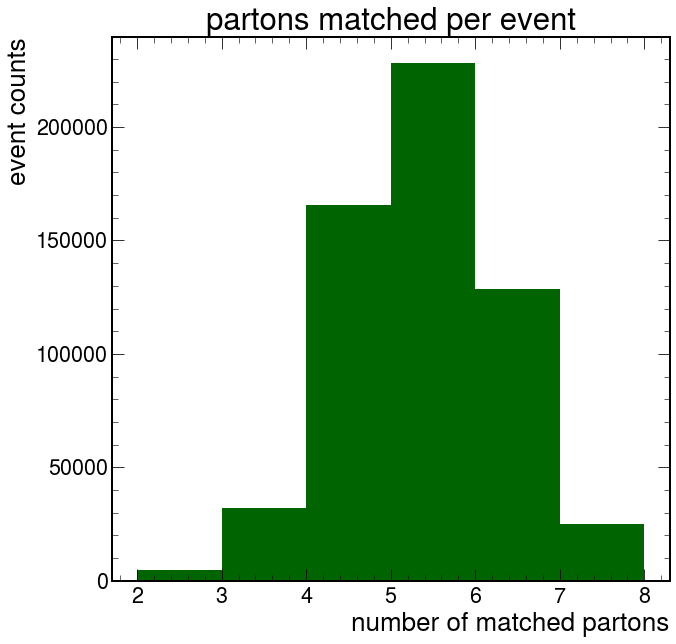

In [58]:
#count number of matched partons per event
partons_knownprov = partons_matched[jets.prov != -1]
matchednum = ak.num(partons_knownprov.prov, axis=1)
plt.hist(matchednum, bins=6, range=(2,8), color="darkgreen")
plt.title("partons matched per event")
plt.xlabel("number of matched partons")
plt.ylabel("event counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/matched_partons_per_event")
plt.show()

In [59]:
#count number of events with 2 matched jets coming from higgs (prov = 1)
jets_higgs = jets[jets.prov == 1]
jets_2higgs = jets_higgs[ak.num(jets_higgs.pt, axis=1) == 2]
eventnum_2higgs = ak.num(jets_2higgs.pt, axis=0)
eventnum_2higgs

350930

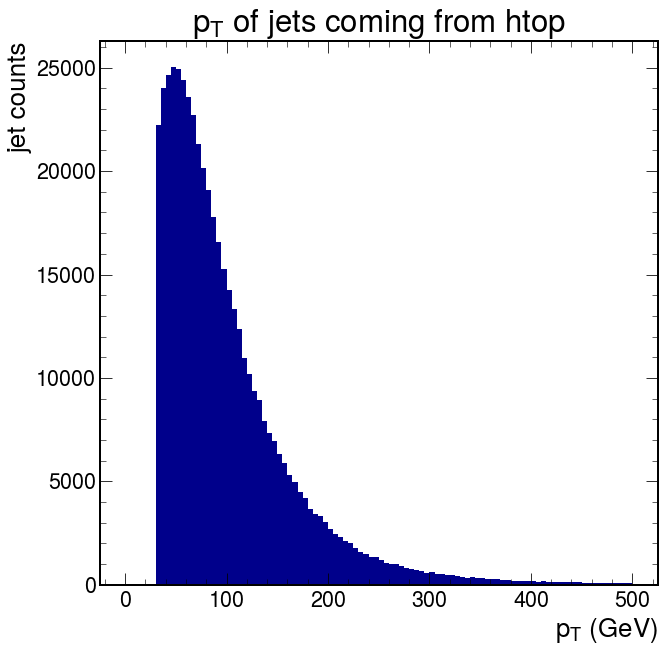

In [60]:
#find jets coming from hadronic top (prov = 2)
jets_htop = jets[jets.prov == 2]

#plot pt of these jets
plt.hist(ak.flatten(jets_htop.pt), bins=100, color="darkblue", range=(0,500))
plt.title(r"$p_T$ of jets coming from htop")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("jet counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/pt_from_htop")
plt.show()

# Invariant Mass

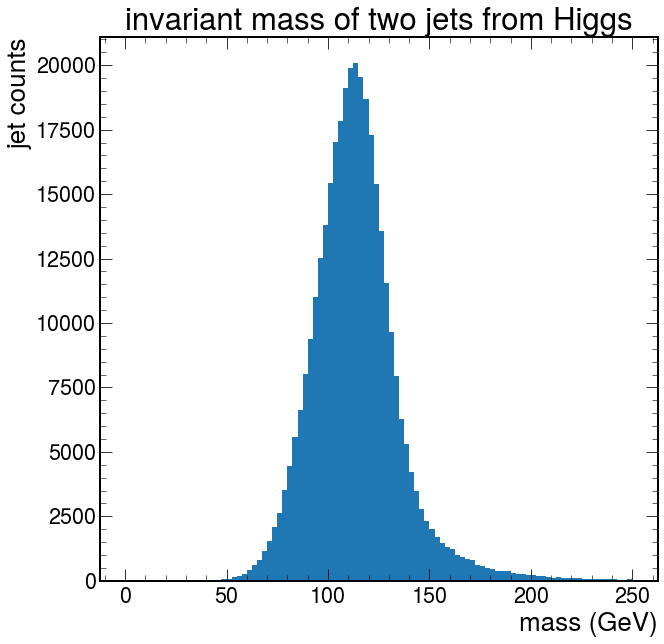

In [61]:
#invariant mass of two jets coming from higgs
summed_jets_higgs = jets_2higgs[:,0] + jets_2higgs[:,1]
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,250))
plt.title("invariant mass of two jets from Higgs")
plt.xlabel("mass (GeV)")
plt.ylabel("jet counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/higgs_invariant_mass")
plt.show()

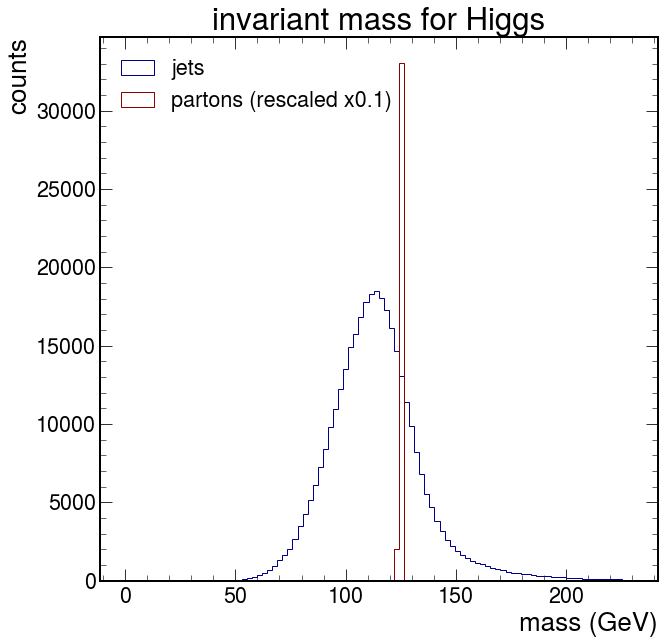

In [62]:
#invariant mass of the sum of the two jets associated with the Higgs
summed_jets_higgs, summed_partons_higgs = generate_summed(jets, partons_matched, 1)
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,230), color="darkblue", histtype="step", label="jets")

#invariant mass of the sum of the two partons associated with the Higgs
plt.hist(summed_partons_higgs.mass, bins=100, weights=0.1*np.ones_like(summed_partons_higgs.mass), range=(0,230), color="darkred", histtype="step", label="partons (rescaled x0.1)")
plt.title("invariant mass for Higgs")
plt.legend(loc="upper left")
plt.xlabel("mass (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_higgs")
plt.show()

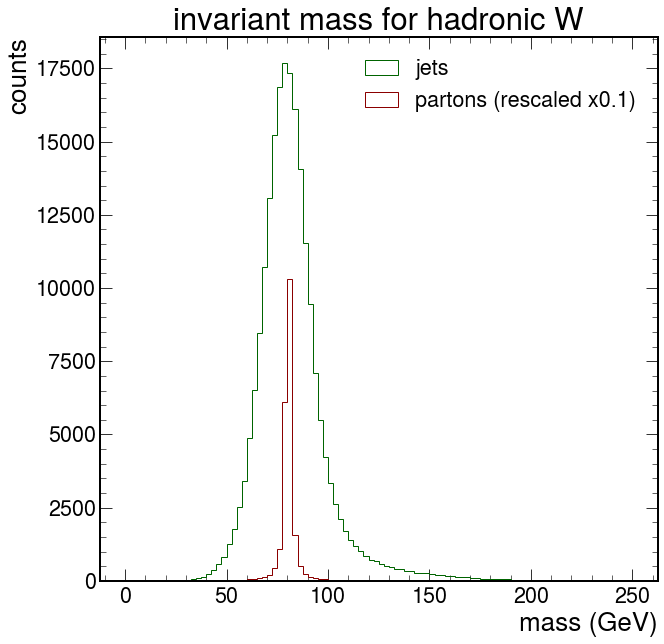

In [63]:
#invariant mass of the sum of the two jets associatied with the hadronically decaying W boson (prov = 5)

summed_jets_W, summed_partons_W = generate_summed(jets, partons_matched, 5)
plt.hist(summed_jets_W.mass, bins=100, range=(0,250), color="darkgreen", label=("jets"), histtype="step")

#invariant mass of the sum of the two partons associatied with the hadronically decaying W boson (prov = 5)
plt.hist(summed_partons_W.mass, weights=0.1*np.ones_like(summed_partons_W.mass), bins=100, range=(0,250), color="darkred", label=("partons (rescaled x0.1)"), histtype="step")
plt.title("invariant mass for hadronic W")
plt.xlabel("mass (GeV)")
plt.ylabel("counts")
plt.legend()
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_W")
plt.show()


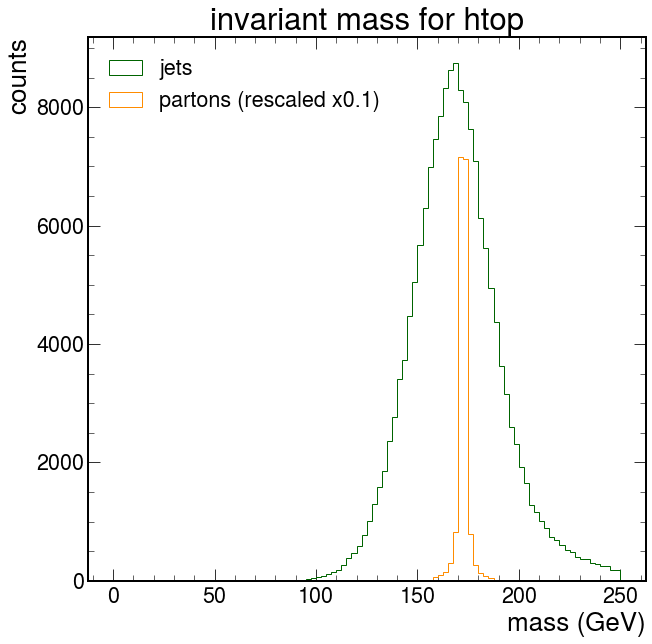

In [64]:
#invariant mass of top hadronically decaying
jets_with_2W = jets[ak.sum(jets.prov == 5, axis=1) == 2]
jets_with_1htop2W = jets_with_2W[ak.sum(jets_with_2W.prov == 2, axis=1) == 1]

partons_with_2W = partons_matched[ak.sum(jets.prov == 5, axis=1) == 2]
partons_with_1htop2W = partons_with_2W[ak.sum(jets_with_2W.prov == 2, axis=1) == 1]

summed_jets_W, summed_partons_W = generate_summed(jets_with_1htop2W, partons_with_1htop2W, 5)

jets_htop = jets_with_1htop2W[jets_with_1htop2W.prov == 2]
jets_1htop = jets_htop[ak.num(jets_htop.pt, axis=1) == 1]
summed_jets_htop = jets_1htop
    
partons_htop = partons_with_1htop2W[jets_with_1htop2W.prov == 2]
partons_1htop = partons_htop[ak.num(partons_htop.pt, axis=1) == 1]
summed_partons_htop = partons_1htop

total_sum_jets = summed_jets_W + summed_jets_htop
total_sum_partons = summed_partons_W + summed_partons_htop

plt.hist(total_sum_jets.mass, bins=100, range=(0,250), color="darkgreen", label="jets", histtype="step")
plt.hist(total_sum_partons.mass, weights=0.1*np.ones_like(total_sum_partons.mass), bins=100, range=(0,250), color="darkorange", label="partons (rescaled x0.1)", histtype="step")
plt.title("invariant mass for htop")
plt.legend(loc="upper left")
plt.xlabel("mass (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_htop")
plt.show()

# Higgs Correlations

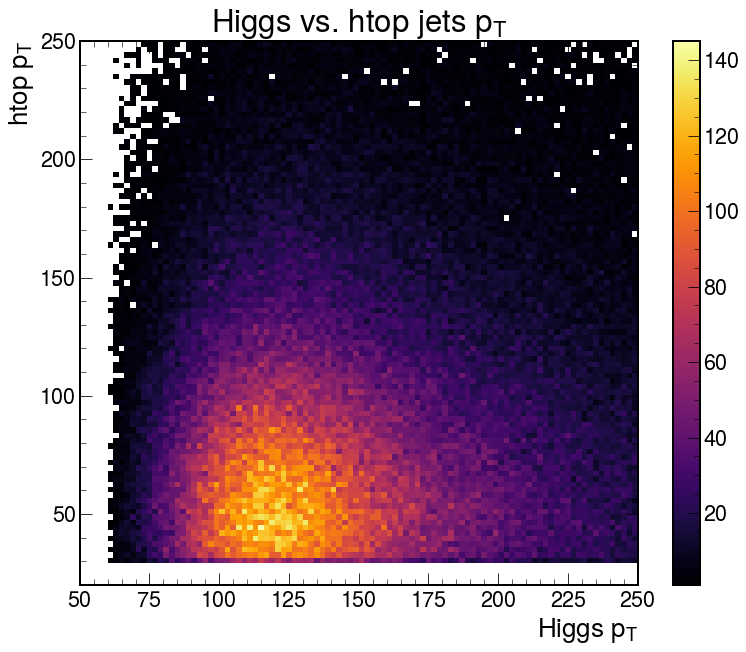

In [65]:
#higgs vs htop
jets_with_2higgs1htop, partons_with_2higgs1htop = select_include(jets, partons_matched, [1, 2], [2, 1])
higgs_jets, higgs_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 1)
htop_jets, htop_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 2)
higgs_pt = ak.sum(higgs_jets.pt, axis=1)
htop_pt = ak.sum(htop_jets.pt, axis=1)

plt.figure(figsize=(12.5, 10))
plt.hist2d(higgs_pt, htop_pt, bins=(100,100), range=[[50, 250], [20, 250]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("Higgs $p_T$")
plt.ylabel("htop $p_T$")
plt.title("Higgs vs. htop jets $p_T$")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Higgs Correlations/Higgs_vs_htop_hist2d")
plt.show()

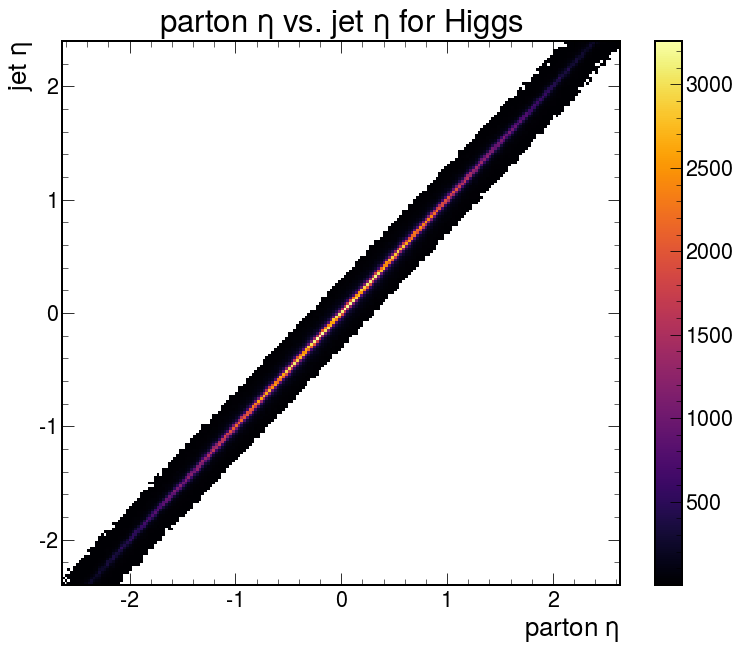

In [66]:
#eta of higgs vs eta of partons
higgs_jets, higgs_partons = select_only(jets, partons_matched, 1)
jet_eta = higgs_jets.eta
parton_eta = higgs_partons.eta
jet_eta = ak.flatten(jet_eta)
parton_eta = ak.flatten(parton_eta)

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_eta, jet_eta, bins=(200,200), cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("parton $\eta$")
plt.ylabel("jet $\eta$")
plt.title("parton $\eta$ vs. jet $\eta$ for Higgs")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Higgs Correlations/Higgs_eta_parton_vs_jet_hist2d")
plt.show()

# Boost

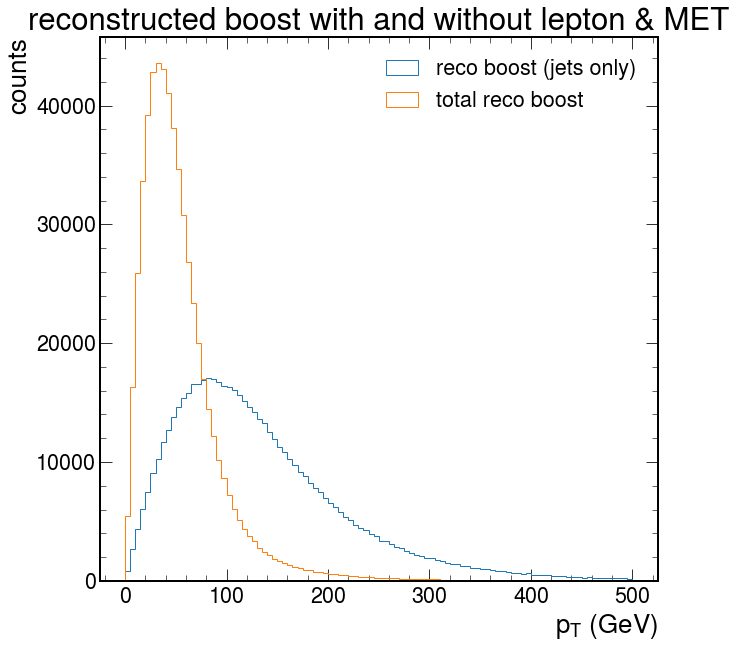

In [67]:
plt.hist(boost_jets.pt, bins=100, label="reco boost (jets only)", range=(0, 500), histtype="step")
plt.hist(boost_reco.pt, bins=100, label="total reco boost", range=(0, 500), histtype="step")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("counts")
plt.legend()
plt.title("reconstructed boost with and without lepton & MET")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pt_with_and_without_leptonMET")
plt.show()

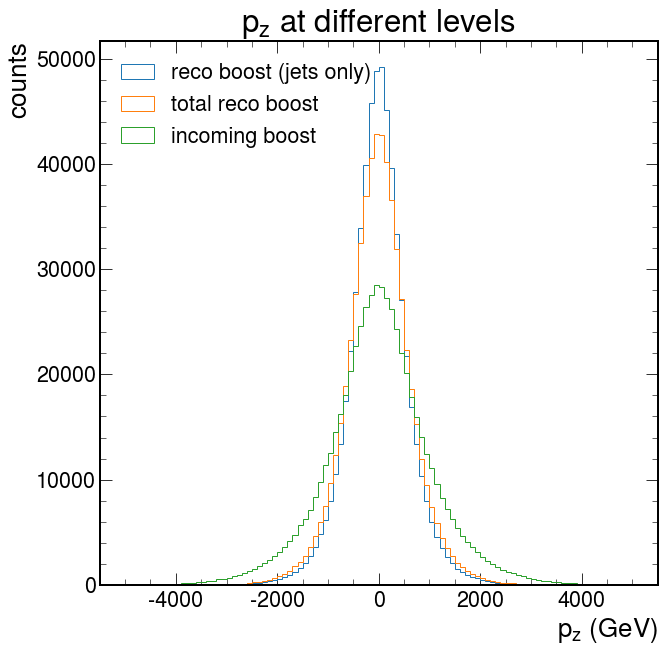

In [68]:
plt.hist(boost_jets.pz, bins=100, label="reco boost (jets only)", range=(-5000, 5000), histtype="step")
plt.hist(boost_reco.pz, bins=100, label="total reco boost",range=(-5000, 5000), histtype="step")
plt.hist(generator_info.x1 * 6500 - generator_info.x2 * 6500, bins=100, label="incoming boost",range=(-5000, 5000), histtype="step" )
plt.legend(loc="upper left")
plt.title(r"$p_z$ at different levels")
plt.xlabel(r"$p_z$ (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pz_at_different_levels")
plt.show()

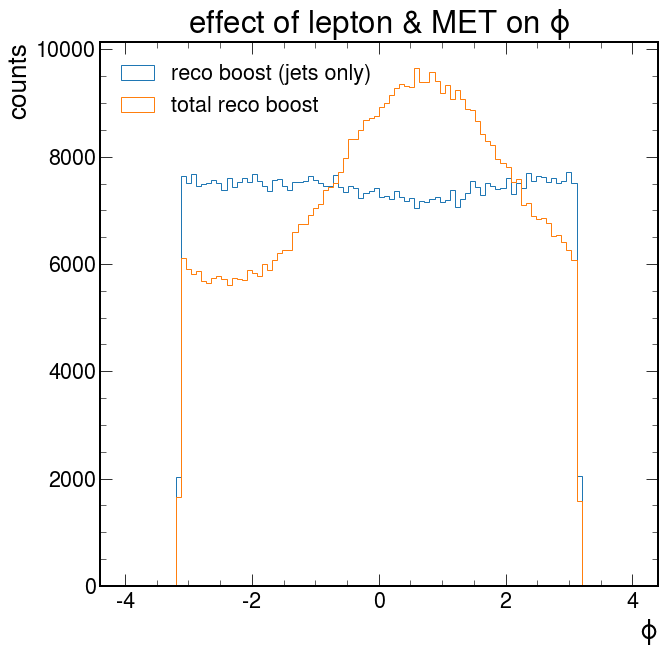

In [69]:
plt.hist(boost_jets.phi, bins=100, label="reco boost (jets only)", range=(-4, 4), histtype="step")
plt.hist(boost_reco.phi, bins=100, label="total reco boost", range=(-4, 4), histtype="step")
plt.xlabel(r"$\phi$")
plt.ylabel("counts")
plt.legend(loc="upper left")
plt.title("effect of lepton & MET on $\phi$")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/phi_with_and_without_leptonMET")
plt.show()

# Lepton & MET

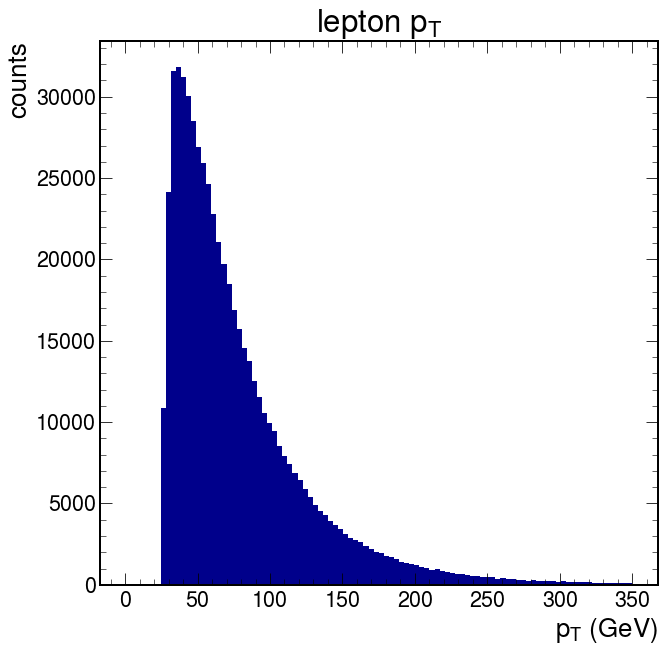

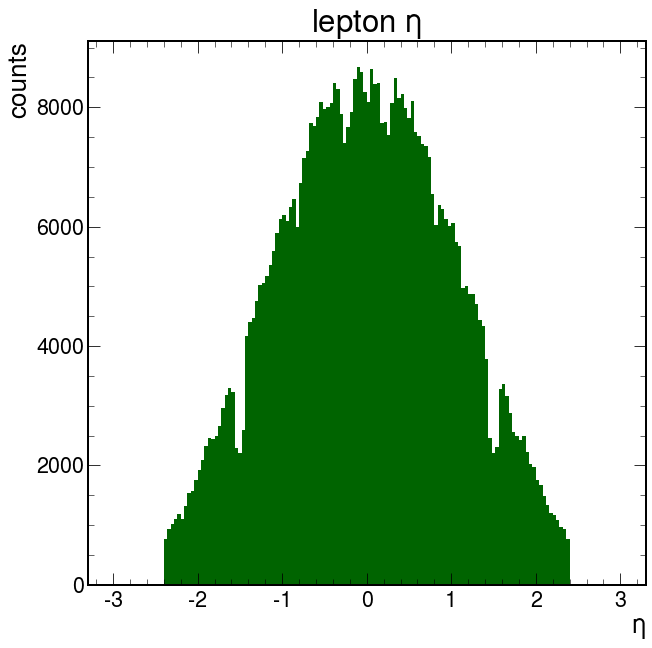

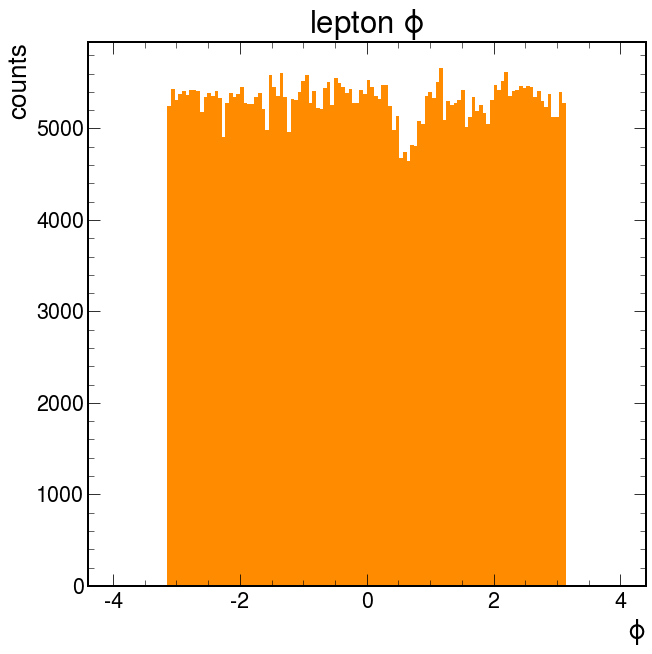

In [70]:
plt.hist(lepton_reco.pt, bins=100, range=(0,350), color="darkblue")
plt.title("lepton $p_T$")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/lepton_pt")
plt.show()

plt.hist(lepton_reco.eta, bins=150, range=(-3, 3), color="darkgreen")
plt.title("lepton $\eta$")
plt.xlabel(r"$\eta$")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/lepton_eta")
plt.show()

plt.hist(lepton_reco.phi, bins=140, range=(-4,4), color="darkorange")
plt.title("lepton $\phi$")
plt.xlabel(r"$\phi$")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/lepton_phi")
plt.show()


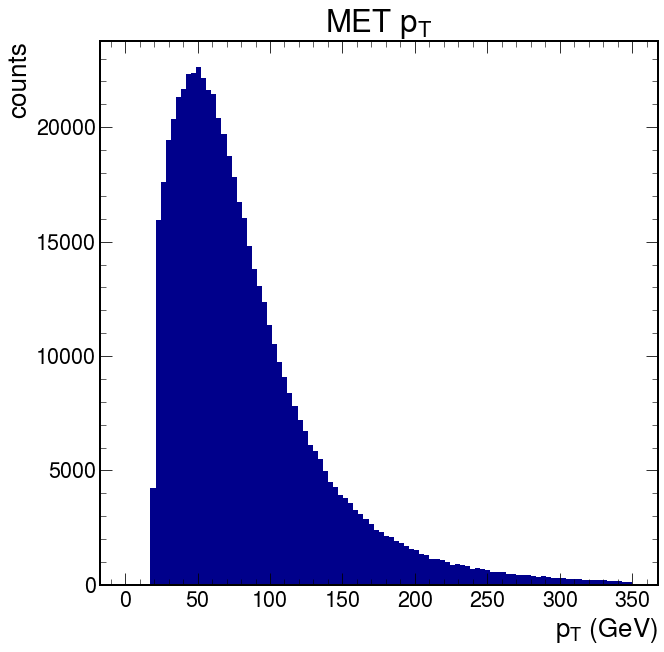

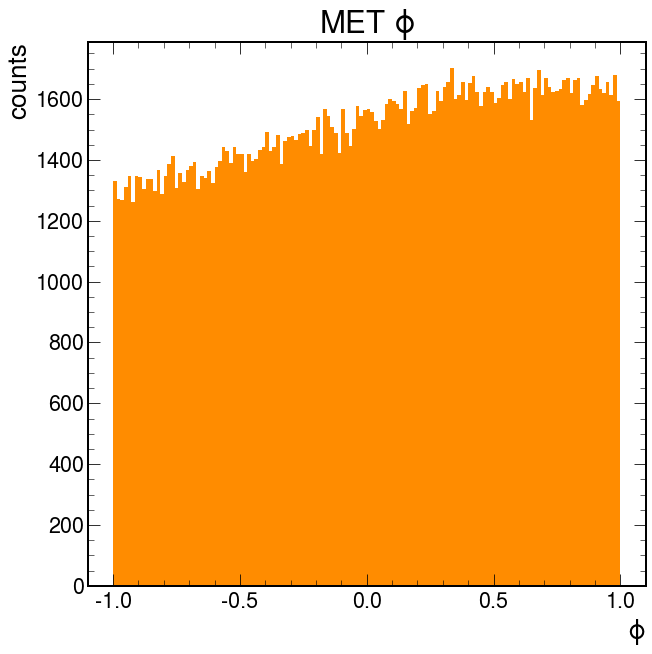

In [71]:
plt.hist(met.pt, bins=100, range=(0,350), color="darkblue")
plt.title("MET $p_T$")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/MET_pt")
plt.show()

plt.hist(met.phi, bins=140, range=(-1, 1), color="darkorange")
plt.title("MET $\phi$")
plt.xlabel(r"$\phi$")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/MET_phi")
plt.show()

# Correlation between lepton & MET

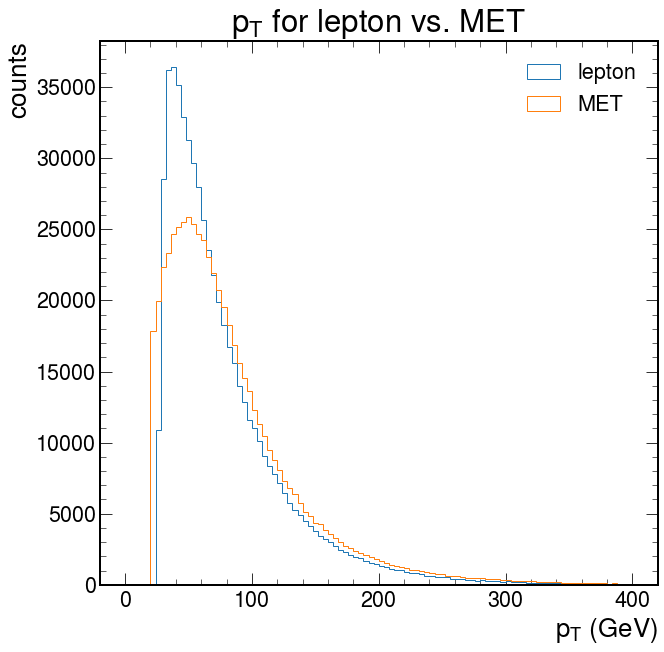

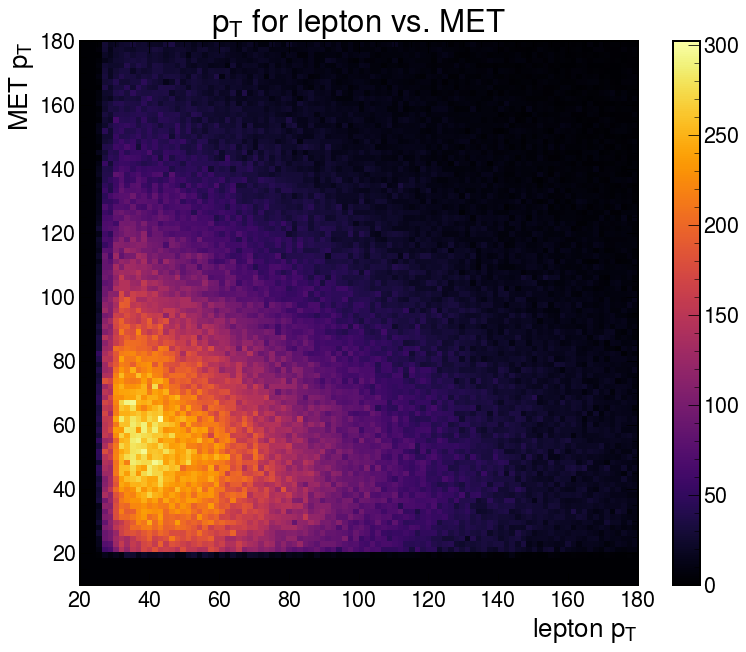

In [72]:
plt.hist(lepton_reco.pt, bins=100, range=(0,400), label="lepton", histtype="step")
plt.hist(met.pt, bins=100, range=(0,400), label="MET", histtype="step")
plt.legend()
plt.xlabel(r"$p_T$ (GeV)")
plt.title(r"$p_T$ for lepton vs. MET")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/pt_lepton_vs_MET")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(lepton_reco.pt, met.pt, bins=(100,100), range=[[20, 180], [10, 180]], cmap="inferno")
plt.colorbar()
plt.xlabel("lepton $p_T$"); plt.ylabel("MET $p_T$")
plt.title(r"$p_T$ for lepton vs. MET")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/pt_lepton_vs_MET_hist2d")
plt.show()

# Invariant mass of lepton & MET

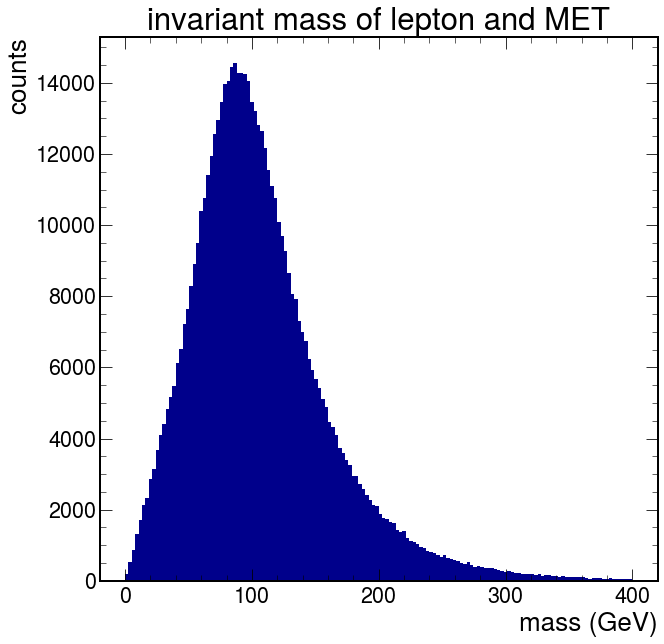

In [73]:
summed_reco = lepton_reco + met
plt.hist(summed_reco.mass, bins=150, range=(0, 400), color="darkblue")
plt.xlabel("mass (GeV)")
plt.title("invariant mass of lepton and MET")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Lepton and MET/invariant_mass_leptonMET")
plt.show()

# Correlations between reco boost (jets only) and lepton

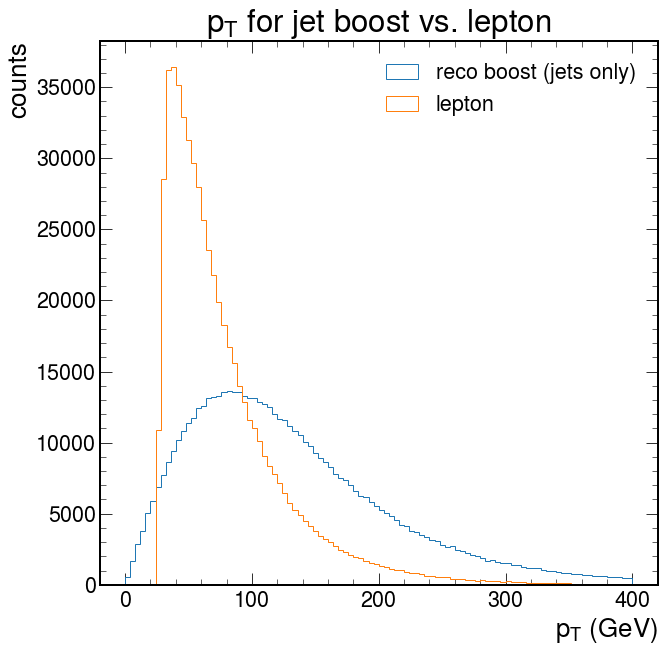

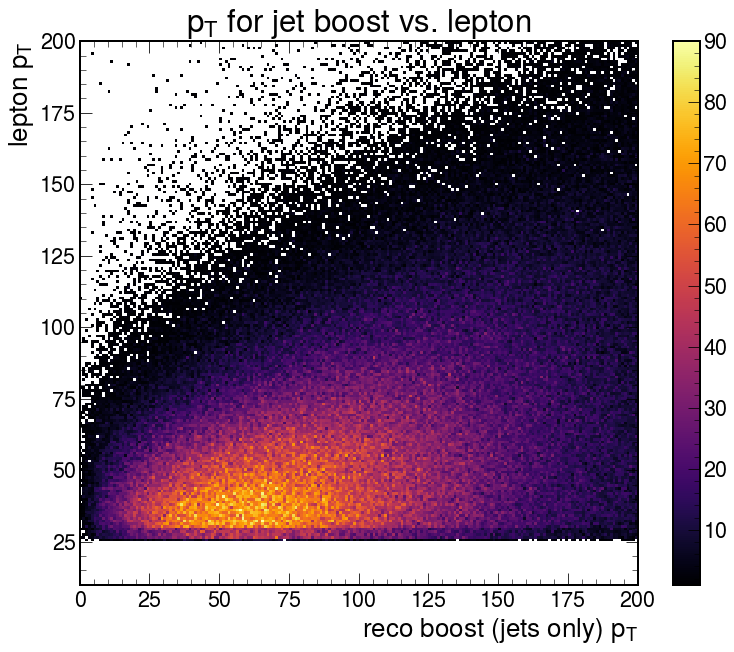

In [74]:
plt.hist(boost_jets.pt, bins=100, range=(0,400), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.pt, bins=100, range=(0,400), label="lepton", histtype="step")
plt.legend()
plt.title(r"$p_T$ for jet boost vs. lepton")
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("counts")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pt_jetboost_vs_lepton")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.pt, lepton_reco.pt, bins=(200,200), range=[[0, 200], [10, 200]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $p_T$"); plt.ylabel("lepton $p_T$")
plt.title(r"$p_T$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pt_jetboost_vs_lepton_hist2d")
plt.show()

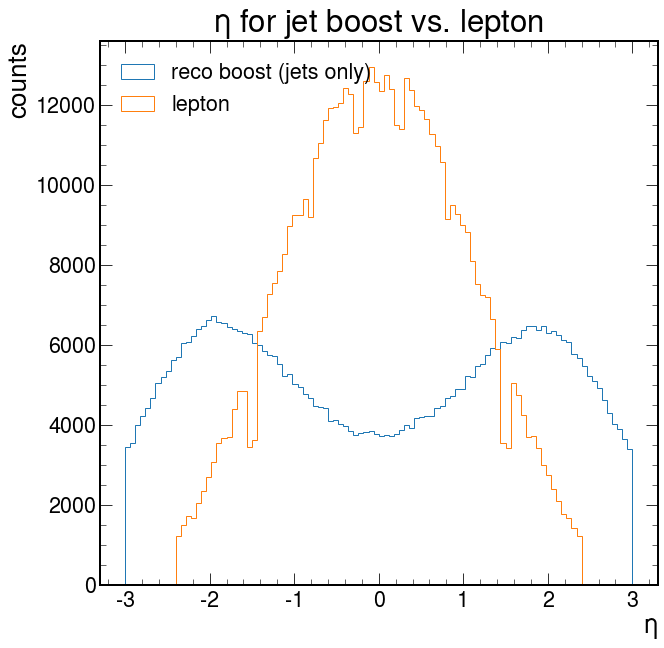

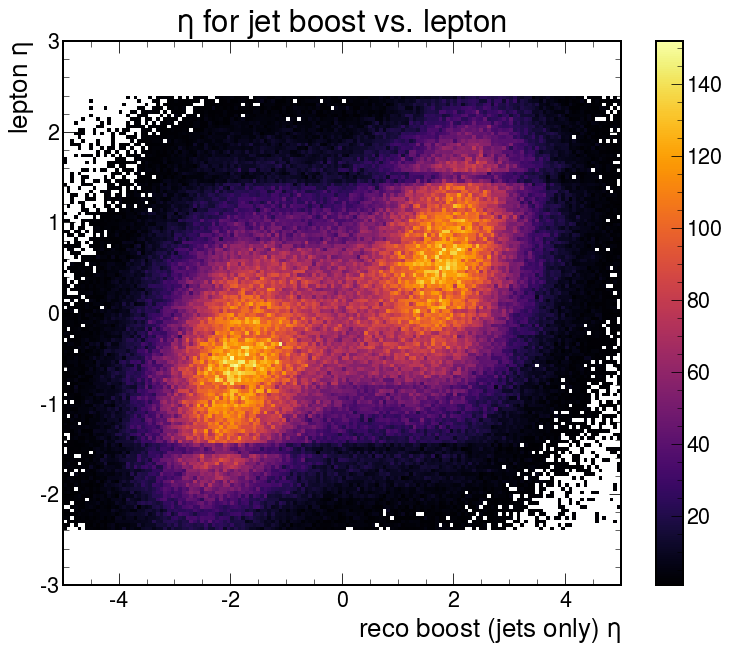

In [75]:
plt.hist(boost_jets.eta, bins=100, range=(-3, 3), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.eta, bins=100, range=(-3, 3), label="lepton", histtype="step")
plt.legend(loc="upper left")
plt.xlabel(r"$\eta$")
plt.ylabel("counts")
plt.title(r"$\eta$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/eta_jetboost_vs_lepton")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.eta, lepton_reco.eta, bins=(150,150), range=[[-5, 5], [-3, 3]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $\eta$"); plt.ylabel("lepton $\eta$")
plt.title(r"$\eta$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/eta_jetboost_vs_lepton_hist2d")
plt.show()

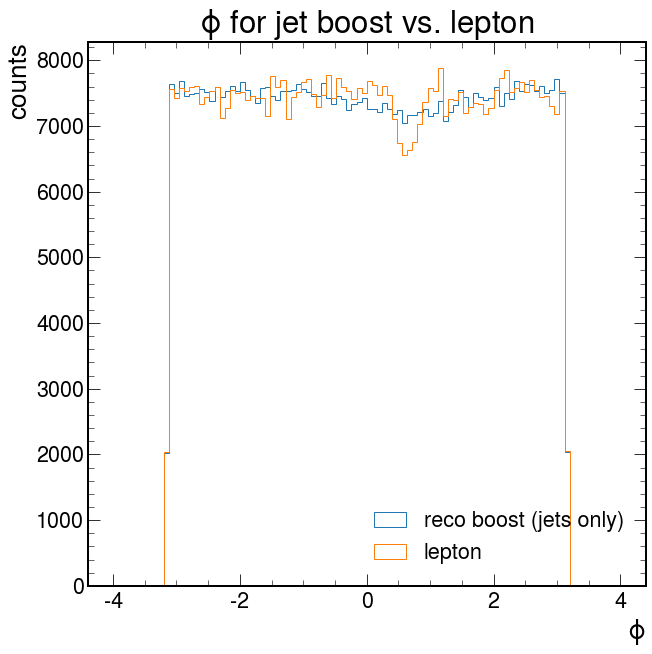

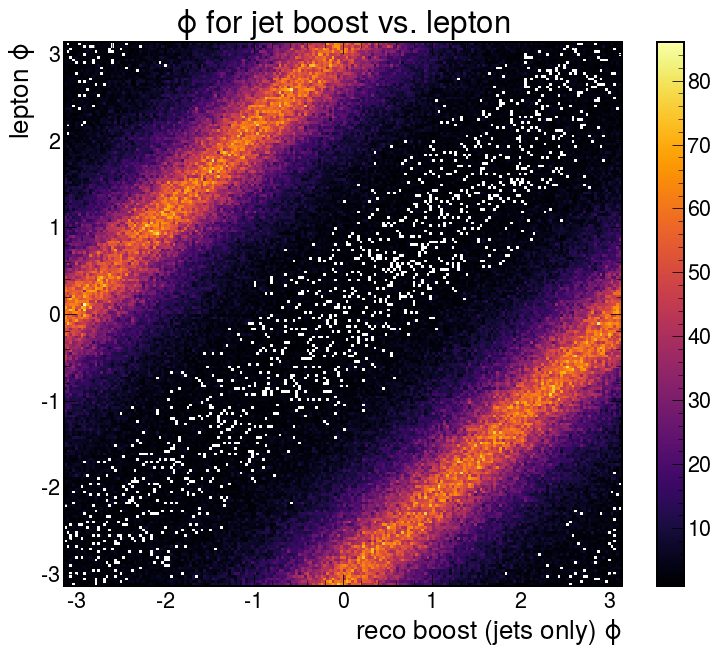

In [76]:
plt.hist(boost_jets.phi, bins=100, range=(-4, 4), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.phi, bins=100, range=(-4, 4), label="lepton", histtype="step")
plt.legend(loc="lower right")
plt.xlabel(r"$\phi$")
plt.ylabel("counts")
plt.title(r"$\phi$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/phi_jetboost_vs_lepton")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.phi, lepton_reco.phi, bins=(200,200), cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $\phi$"); plt.ylabel("lepton $\phi$")
plt.title(r"$\phi$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/phi_jetboost_vs_lepton_hist2d")
plt.show()

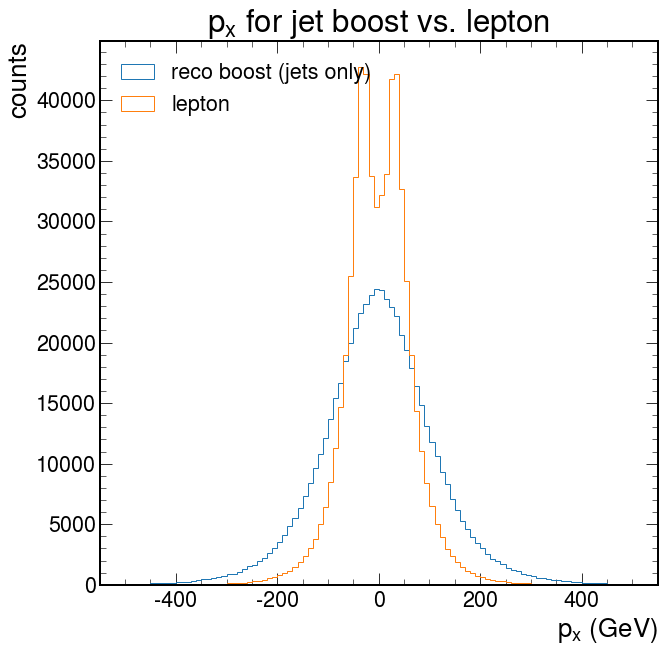

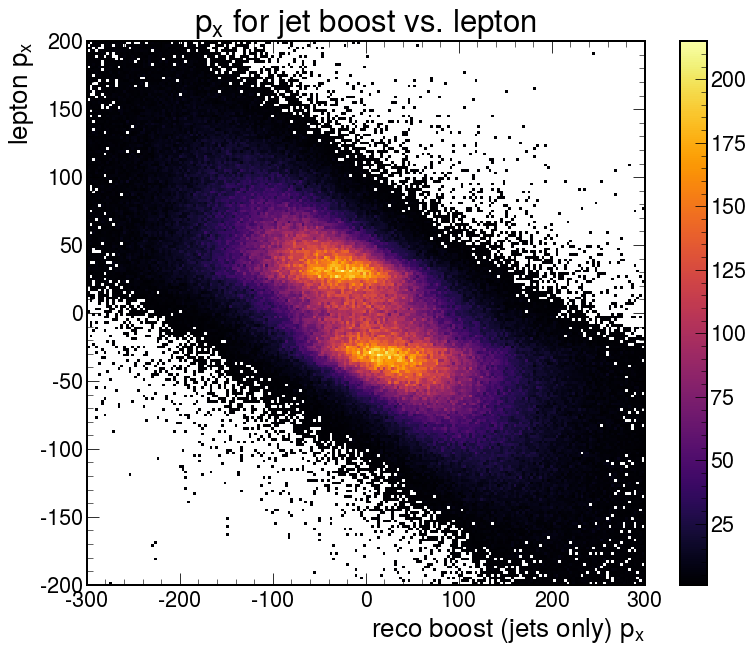

In [77]:
plt.hist(boost_jets.px, bins=100, range=(-500, 500), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.px, bins=100, range=(-500, 500), label="lepton", histtype="step")
plt.legend(loc="upper left")
plt.xlabel(r"$p_x$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_x$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/px_jetboost_vs_lepton")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.px, lepton_reco.px, bins=(200,200), range=[[-300,300], [-200,200]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $p_x$"); plt.ylabel("lepton $p_x$")
plt.title(r"$p_x$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/px_jetboost_vs_lepton_hist2d")
plt.show()

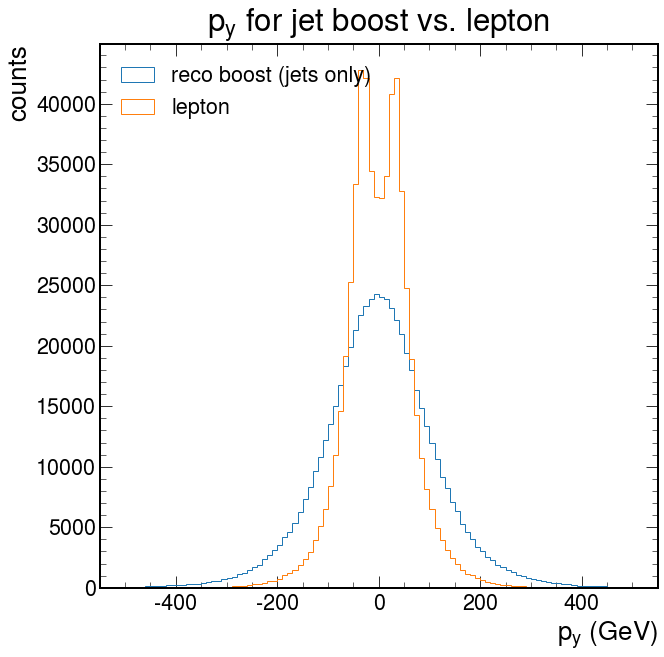

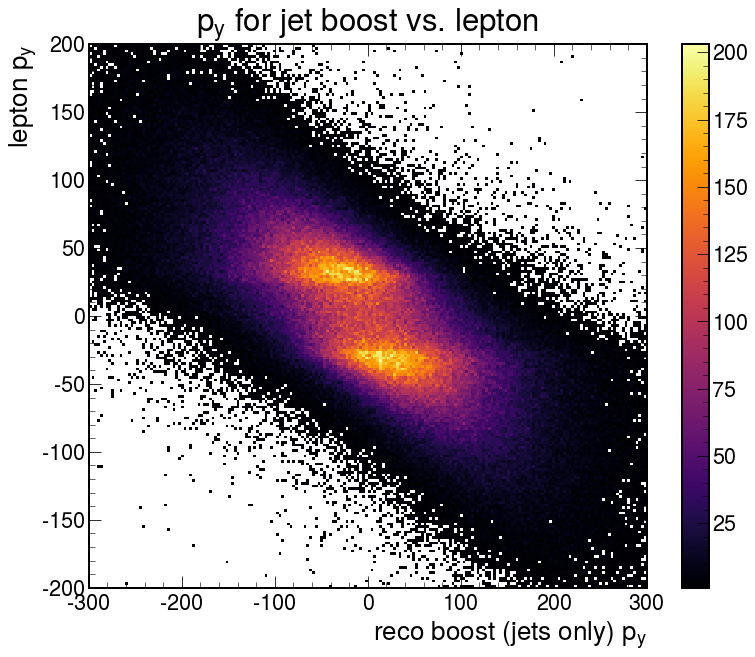

In [78]:
plt.hist(boost_jets.py, bins=100, range=(-500, 500), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.py, bins=100, range=(-500, 500), label="lepton", histtype="step")
plt.xlabel(r"$p_y$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_y$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/py_jetboost_vs_lepton")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.py, lepton_reco.py, bins=(200,200), range=[[-300,300], [-200,200]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $p_y$"); plt.ylabel("lepton $p_y$")
plt.title(r"$p_y$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/py_jetboost_vs_lepton_hist2d")
plt.show()

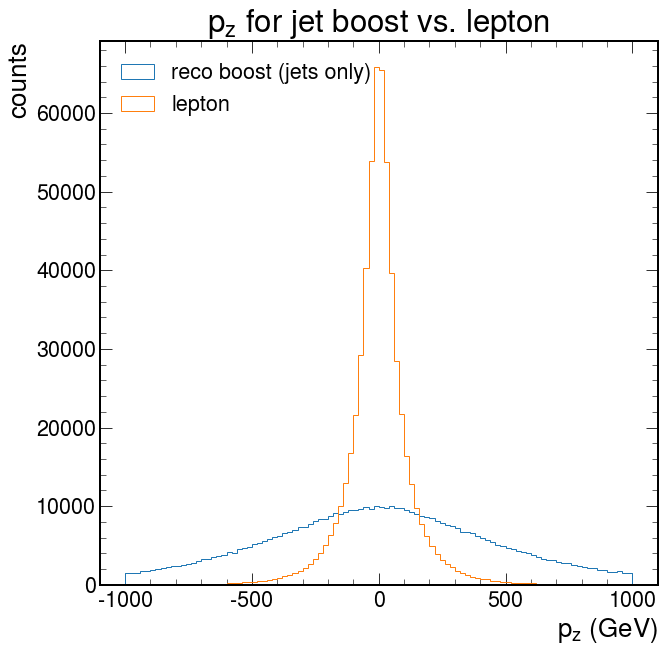

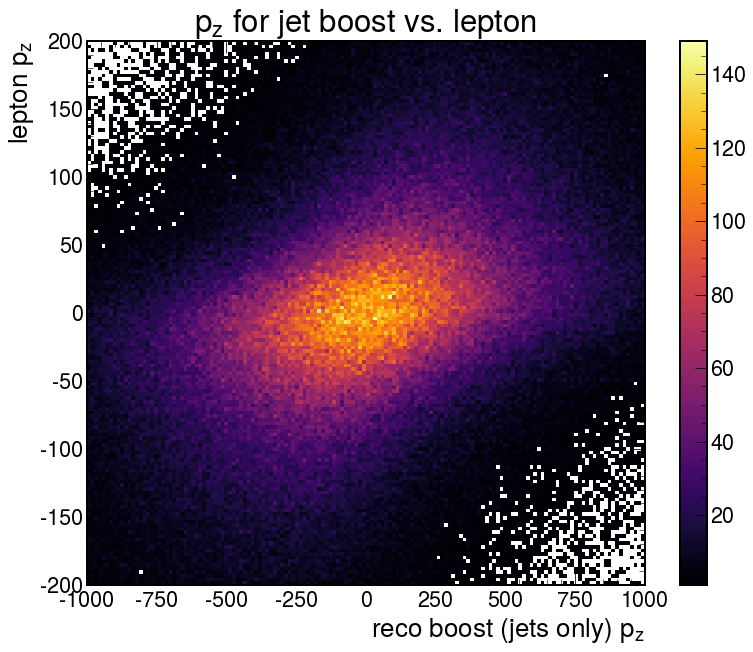

In [79]:
plt.hist(boost_jets.pz, bins=100, range=(-1000, 1000), label="reco boost (jets only)", histtype="step")
plt.hist(lepton_reco.pz, bins=100, range=(-1000, 1000), label="lepton", histtype="step")
plt.xlabel(r"$p_z$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_z$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pz_jetboost_vs_lepton")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(boost_jets.pz, lepton_reco.pz, bins=(150,150), range=[[-1000,1000], [-200,200]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("reco boost (jets only) $p_z$"); plt.ylabel("lepton $p_z$")
plt.title(r"$p_z$ for jet boost vs. lepton")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Jet Boost and Lepton/pz_jetboost_vs_lepton_hist2d")
plt.show()

# Correlations between initial energies and reco boost

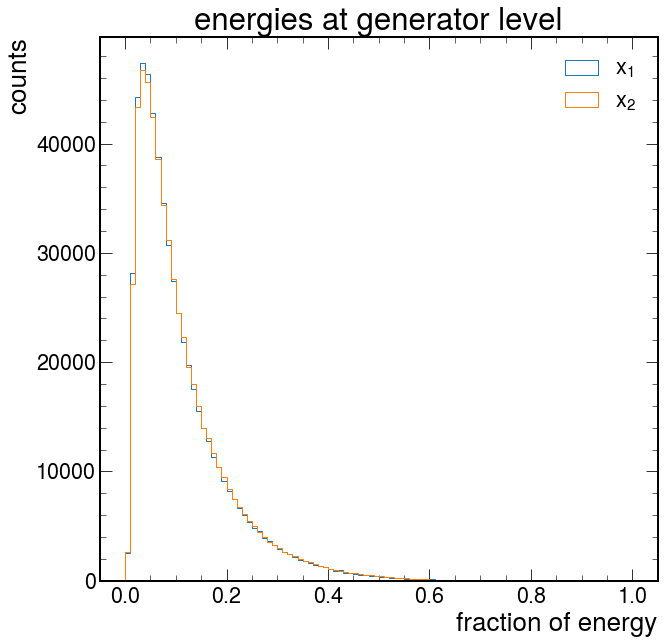

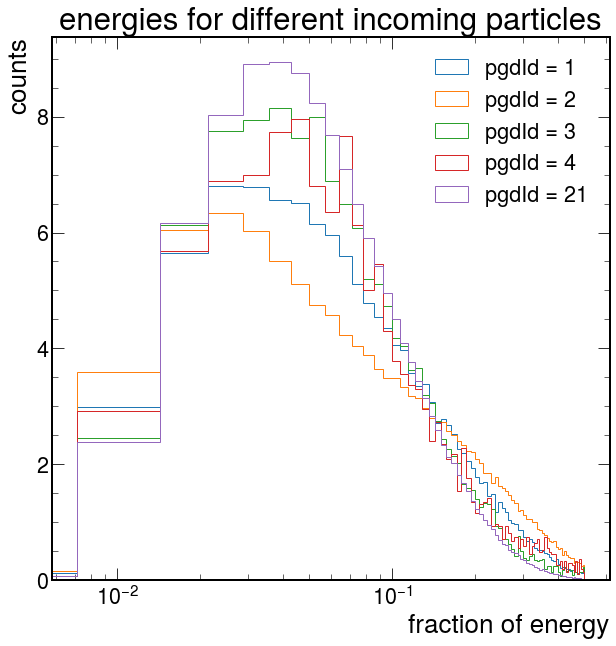

In [80]:
plt.hist(generator_info.x1, bins=100, label=r"$x_1$", range=(0, 1), histtype="step")
plt.hist(generator_info.x2, bins=100, label=r"$x_2$",range=(0, 1), histtype="step")
plt.legend()
plt.xlabel("fraction of energy")
plt.ylabel("counts")
plt.title("energies at generator level")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/x1_x2_hist")
plt.show()

for i in range(22):
    energies = generator_info[abs(generator_info.pdgid1) == i].x1
    if len(energies)  > 3000:
        plt.hist(energies, bins=70, label=f"pgdId = {i}", range=(0, 0.5), histtype="step", density=True)
plt.legend()
plt.xscale("log")
plt.xlabel("fraction of energy")
plt.ylabel("counts")
plt.title("energies for different incoming particles")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/energies_by_pdgId")
plt.show()

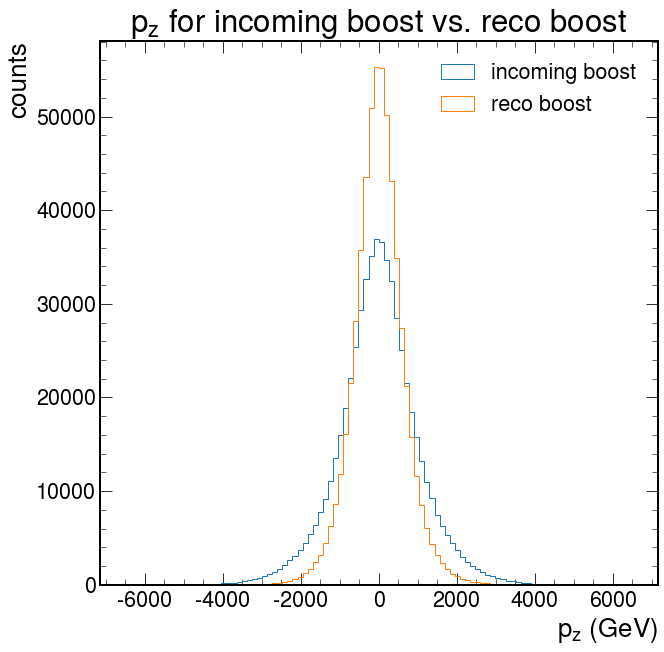

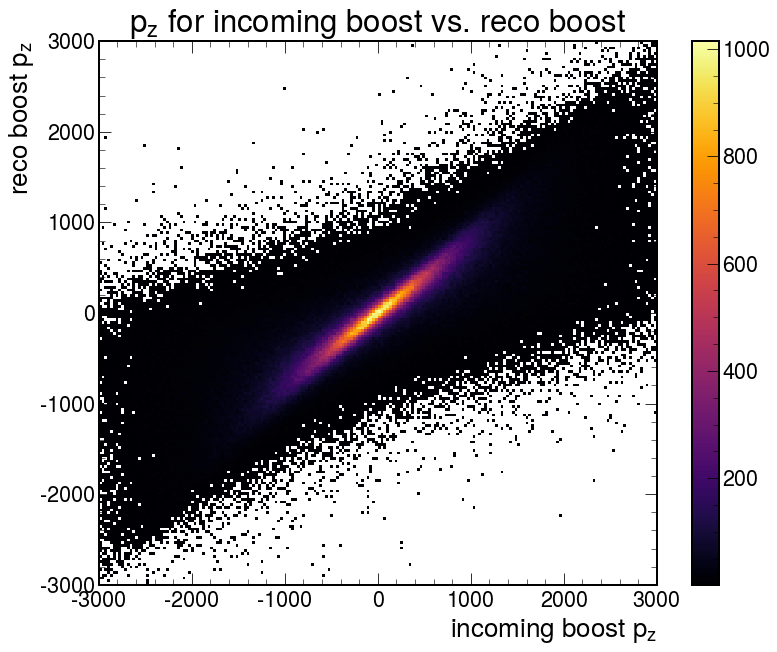

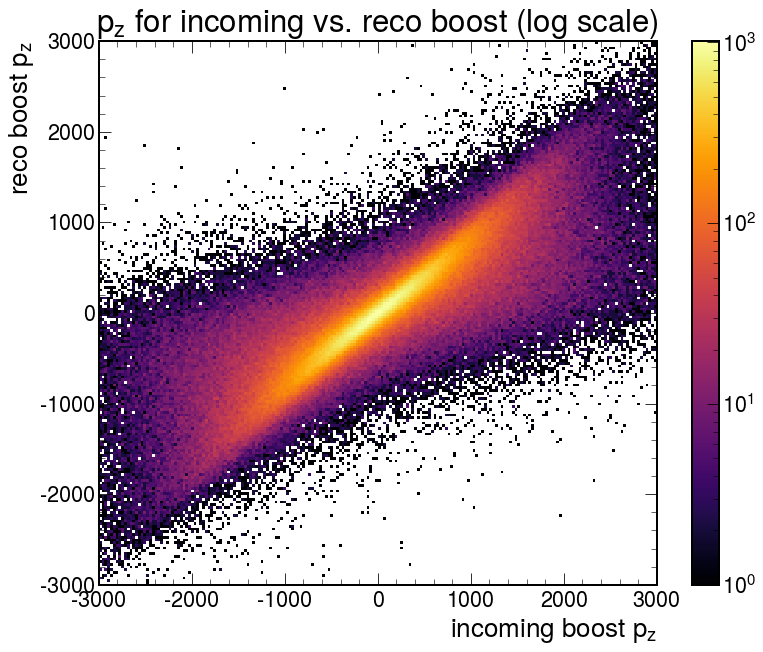

In [81]:
plt.hist(incoming_boost.pz, bins=100, range=(-6500, 6500), label="incoming boost", histtype="step")
plt.hist(boost_reco.pz, bins=100, range=(-6500, 6500), label="reco boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_z$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_z$ for incoming boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/pz_recoboost_vs_incomingboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.pz, boost_reco.pz, bins=(200,200), range=[[-3000,3000], [-3000,3000]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("incoming boost $p_z$"); plt.ylabel("reco boost $p_z$")
plt.title(r"$p_z$ for incoming boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/pz_recoboost_vs_incomingboost_hist2d")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.pz, boost_reco.pz, bins=(200,200), range=[[-3000,3000], [-3000,3000]], cmap="inferno", norm=LogNorm(), cmin=1)
plt.colorbar()
plt.xlabel("incoming boost $p_z$"); plt.ylabel("reco boost $p_z$")
plt.title(r"$p_z$ for incoming vs. reco boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/log_pz_recoboost_vs_incomingboost_hist2d")
plt.show()

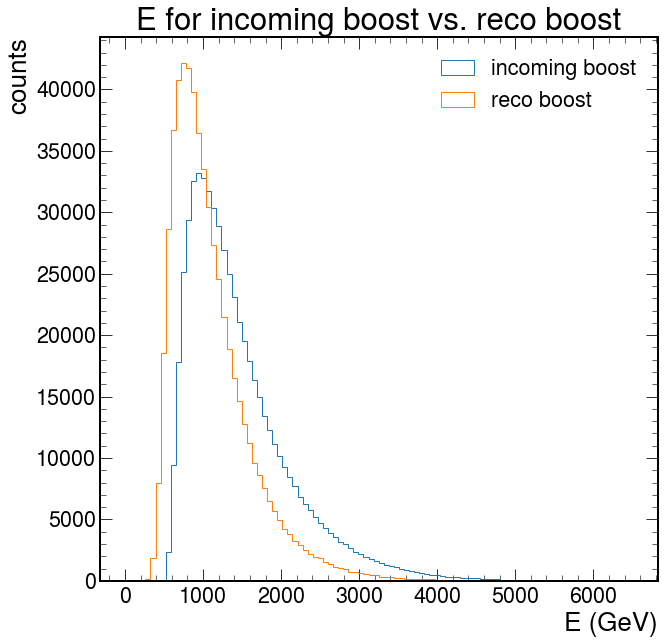

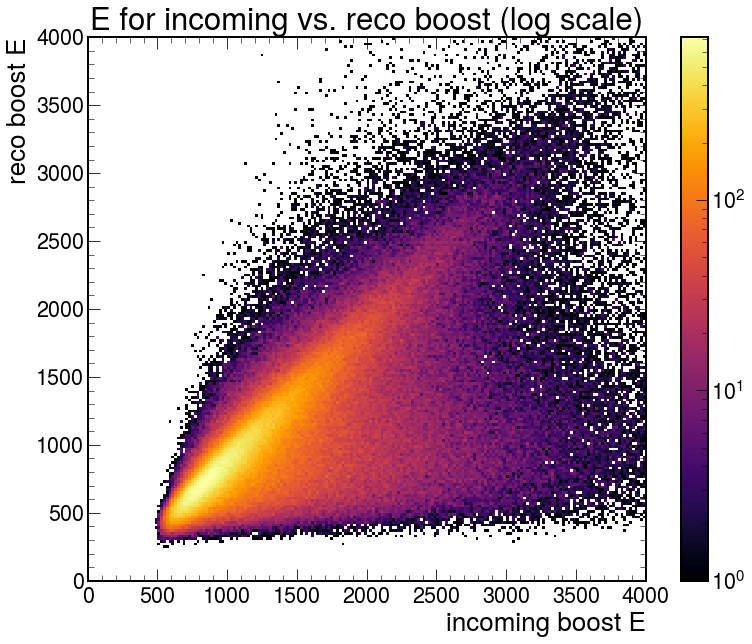

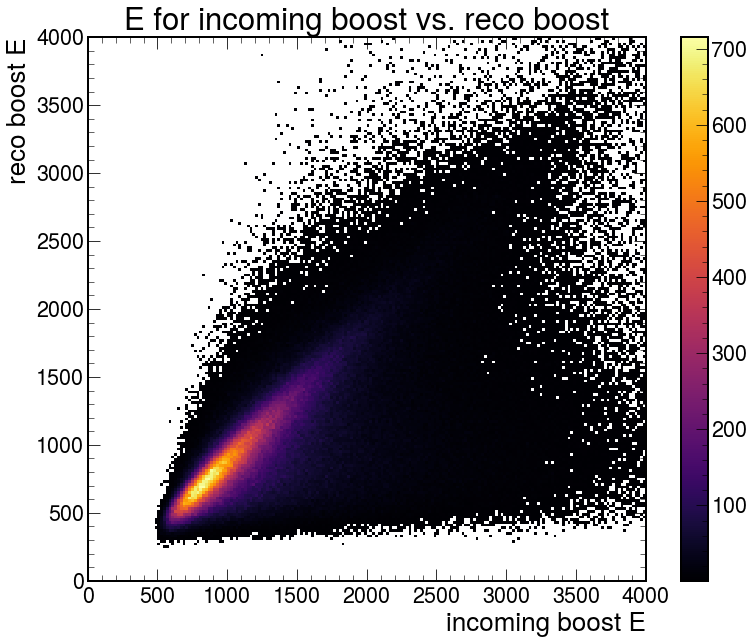

In [82]:
plt.hist(incoming_boost.E, bins=100, range=(0, 6500), label="incoming boost", histtype="step")
plt.hist(boost_reco.E, bins=100, range=(0, 6500), label="reco boost", histtype="step")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("counts")
plt.title("E for incoming boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/E_recoboost_vs_incomingboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.E, boost_reco.E, bins=(200,200), range=[[0,4000], [0,4000]], cmap="inferno", norm=LogNorm())
plt.colorbar()
plt.xlabel("incoming boost E"); plt.ylabel("reco boost E")
plt.title("E for incoming vs. reco boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/log_E_recoboost_vs_incomingboost_hist2d")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.E, boost_reco.E, bins=(200,200), range=[[0,4000], [0,4000]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("incoming boost E"); plt.ylabel("reco boost E")
plt.title("E for incoming boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Reco Boost/E_recoboost_vs_incomingboost_hist2d")
plt.show()

# Correlation between parton boost and reconstructed boost

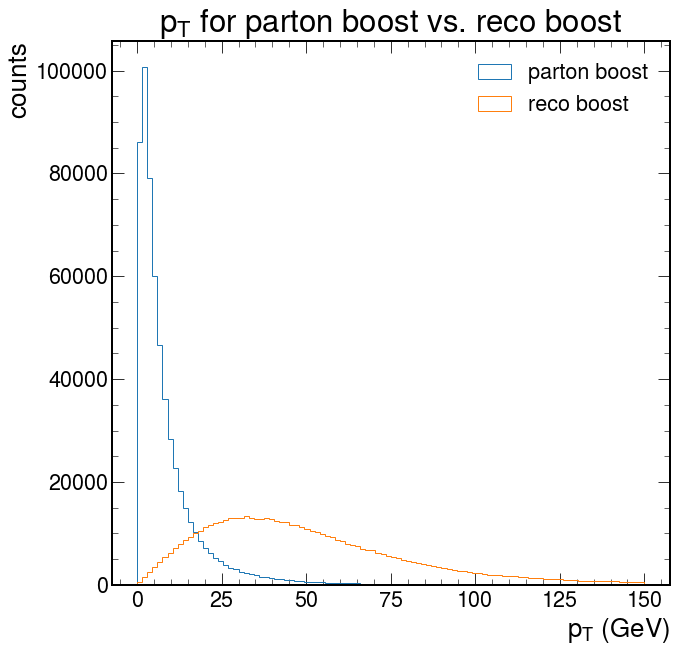

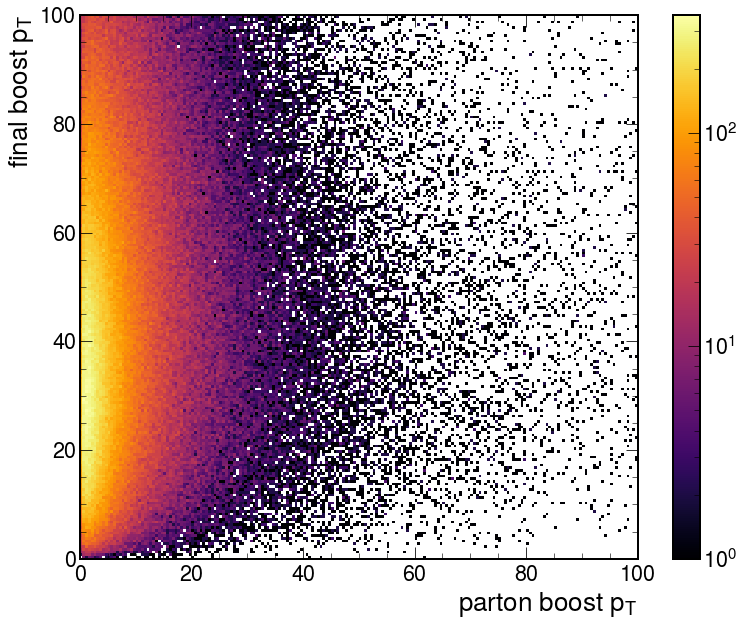

In [83]:
plt.hist(parton_boost.pt, bins=100, range=(0,150), label="parton boost", histtype="step")
plt.hist(boost_reco.pt, bins=100, range=(0,150), label="reco boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_T$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_T$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/pt_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.pt, boost_reco.pt, bins=(200,200), range=[[0, 100], [0, 100]], cmap="inferno", norm=LogNorm())
plt.colorbar()
plt.xlabel("parton boost $p_T$"); plt.ylabel("final boost $p_T$")
plt.show()

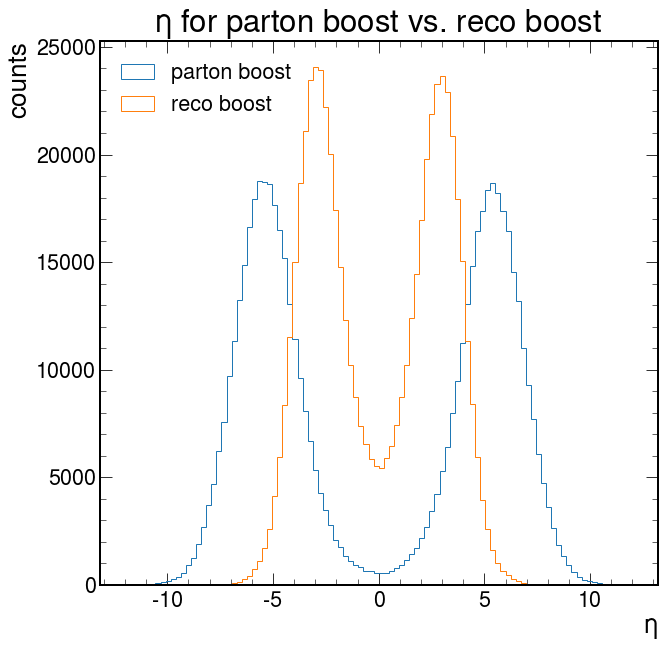

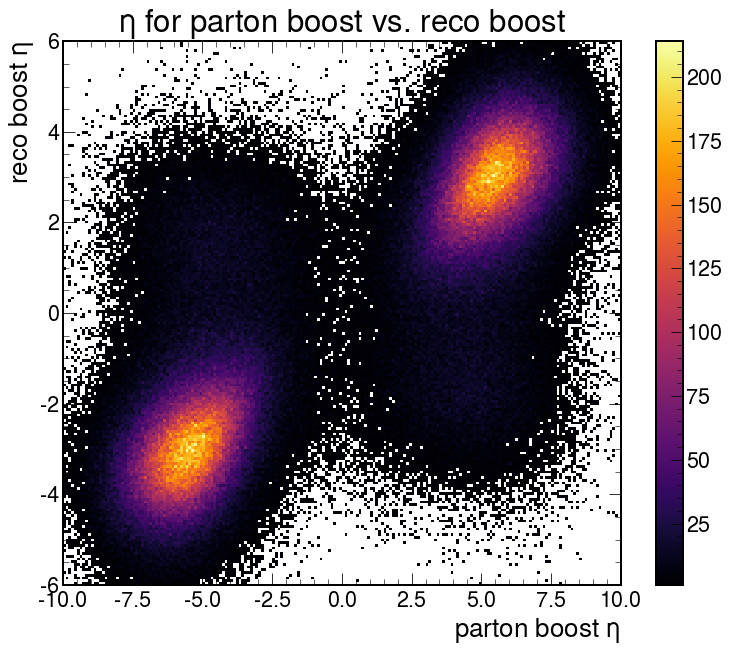

In [84]:
plt.hist(parton_boost.eta, bins=100, range=(-12, 12), label="parton boost", histtype="step")
plt.hist(boost_reco.eta, bins=100, range=(-12, 12), label="reco boost", histtype="step")
plt.legend(loc="upper left")
plt.xlabel(r"$\eta$")
plt.ylabel("counts")
plt.title(r"$\eta$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/eta_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.eta, boost_reco.eta, bins=(200,200), range=[[-10, 10], [-6, 6]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("parton boost $\eta$"); plt.ylabel("reco boost $\eta$")
plt.title(r"$\eta$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/eta_partonboost_vs_recoboost_hist2d")
plt.show()



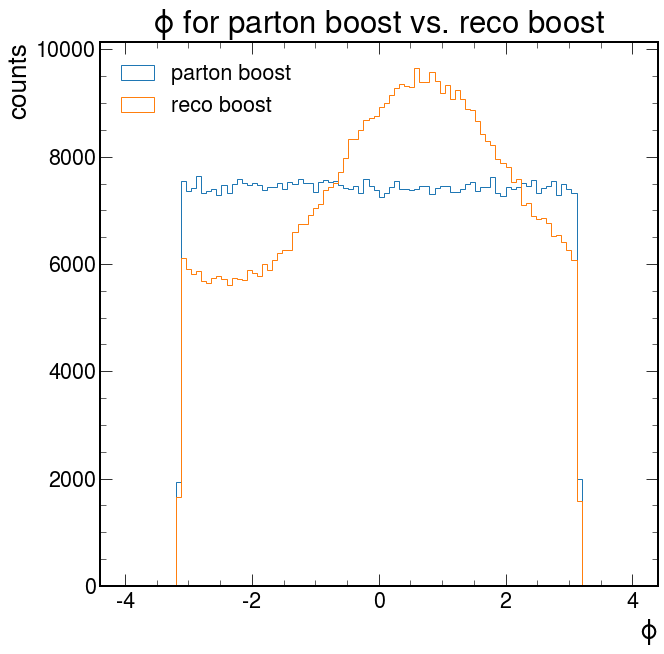

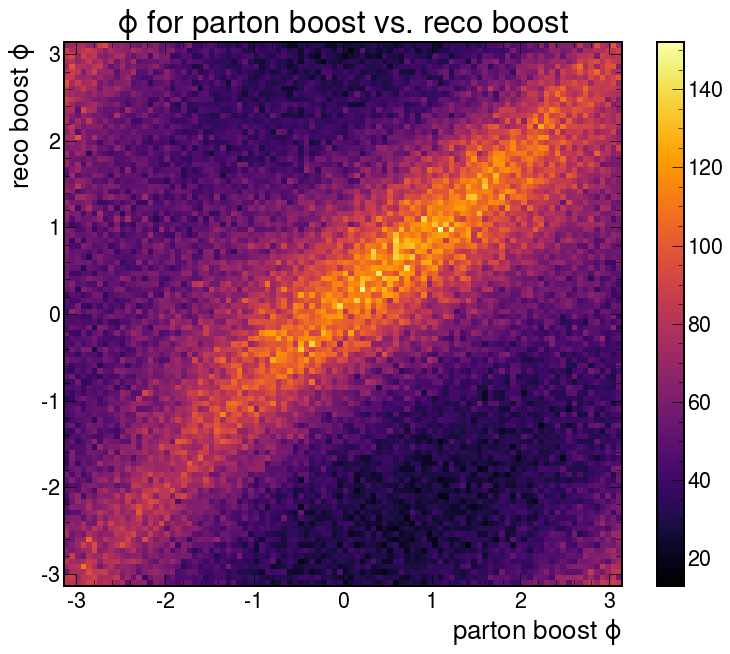

In [85]:
plt.hist(parton_boost.phi, bins=100, range=(-4, 4), label="parton boost", histtype="step")
plt.hist(boost_reco.phi, bins=100, range=(-4, 4), label="reco boost", histtype="step")
plt.legend(loc="upper left")
plt.xlabel(r"$\phi$")
plt.ylabel("counts")
plt.title(r"$\phi$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/phi_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.phi, boost_reco.phi, bins=(100,100), cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("parton boost $\phi$"); plt.ylabel("reco boost $\phi$")
plt.title(r"$\phi$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/phi_partonboost_vs_recoboost_hist2d")
plt.show()

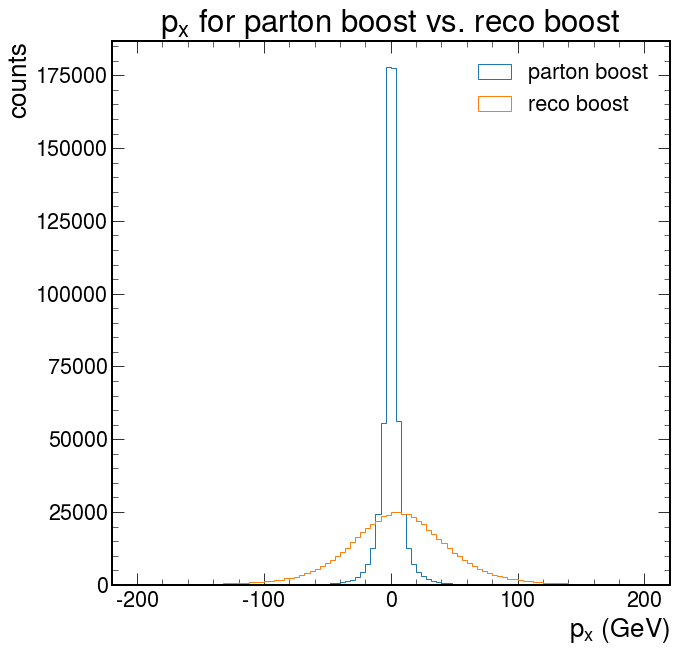

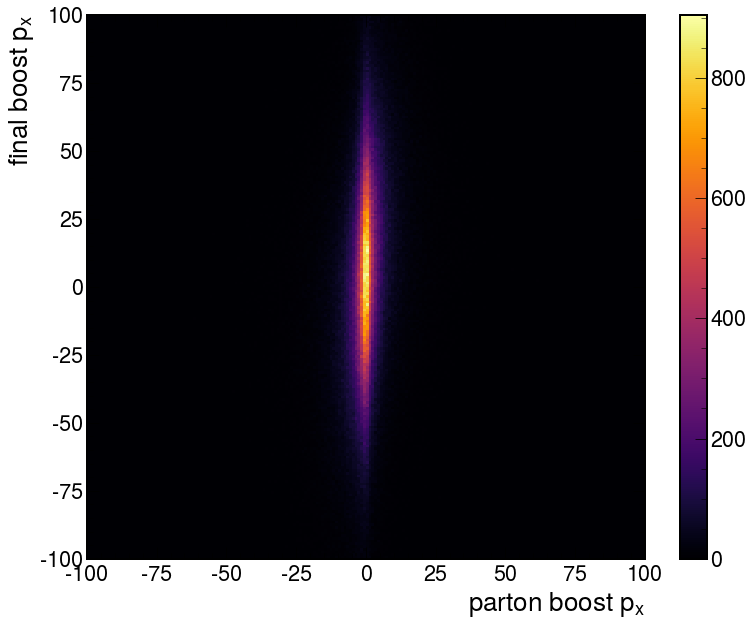

In [86]:
plt.hist(parton_boost.px, bins=100, range=(-200, 200), label="parton boost", histtype="step")
plt.hist(boost_reco.px, bins=100, range=(-200, 200), label="reco boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_x$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_x$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/px_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.px, boost_reco.px, bins=(200,200), range=[[-100,100], [-100,100]], cmap="inferno")
plt.colorbar()
plt.xlabel("parton boost $p_x$"); plt.ylabel("final boost $p_x$")
plt.show()

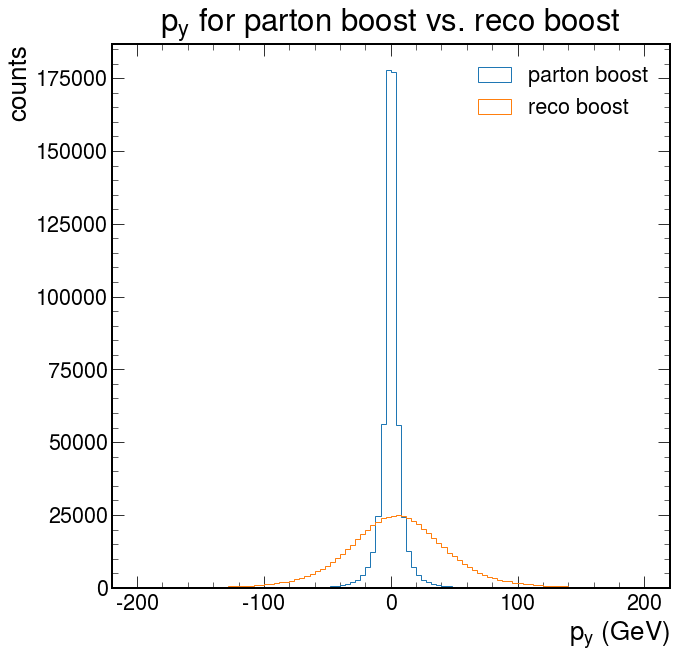

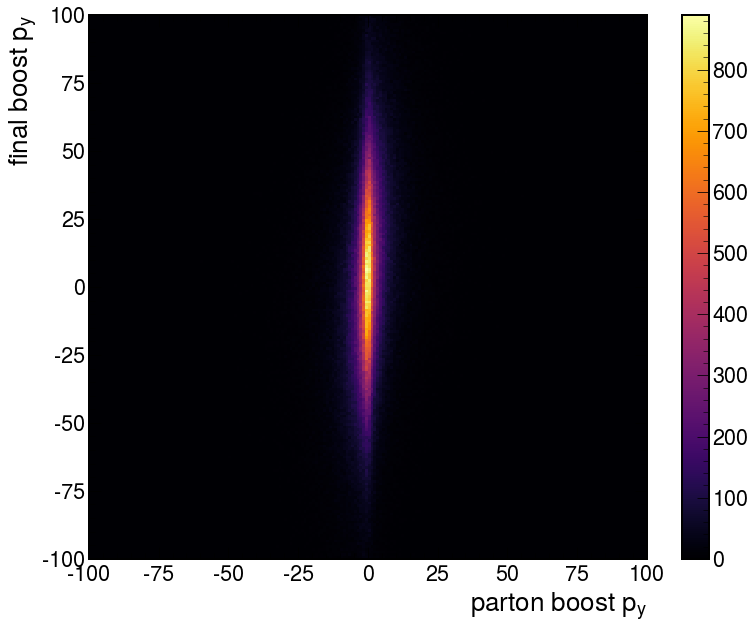

In [87]:
plt.hist(parton_boost.py, bins=100, range=(-200, 200), label="parton boost", histtype="step")
plt.hist(boost_reco.py, bins=100, range=(-200, 200), label="reco boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_y$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_y$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/py_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.py, boost_reco.py, bins=(200,200), range=[[-100,100], [-100,100]], cmap="inferno")
plt.colorbar()
plt.xlabel("parton boost $p_y$"); plt.ylabel("final boost $p_y$")
plt.show()

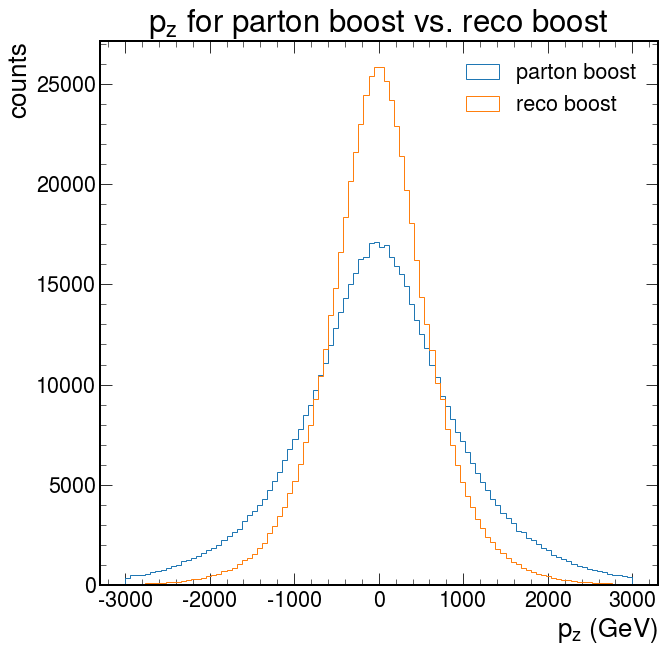

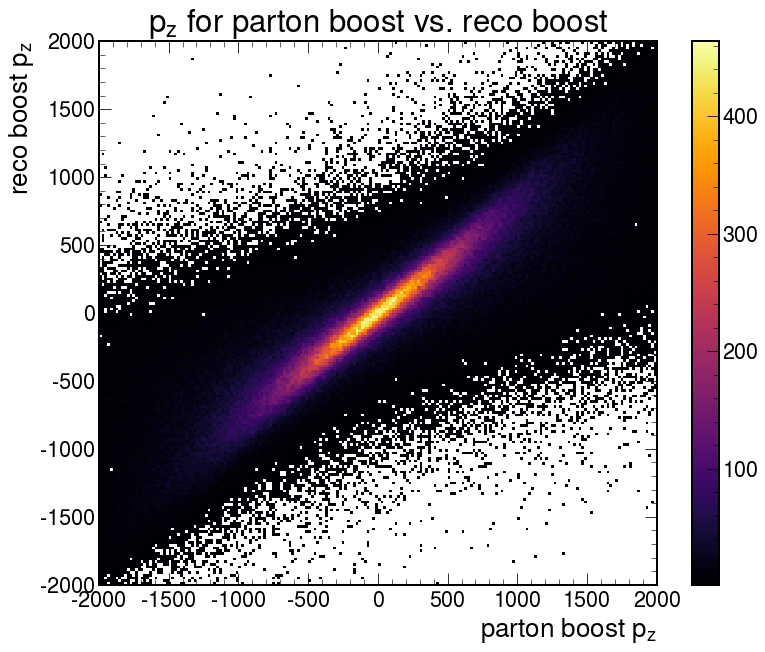

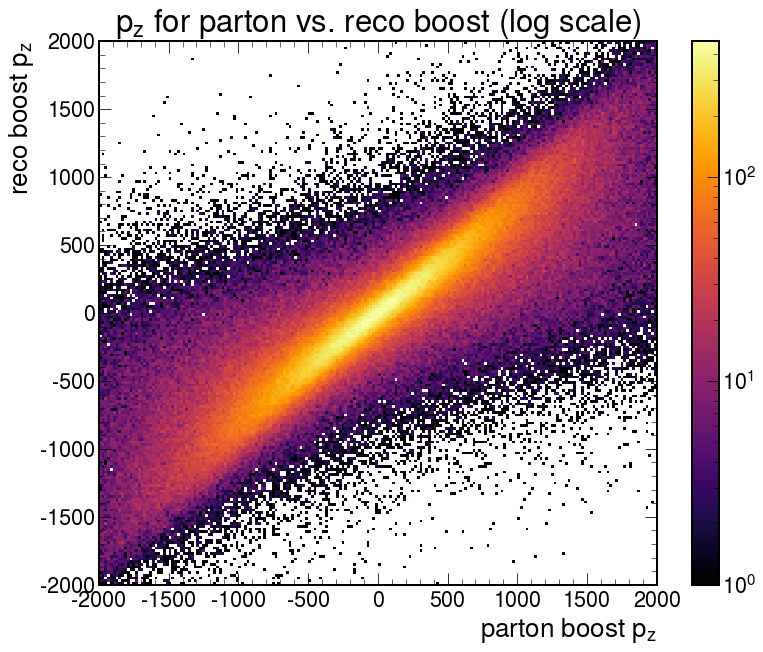

In [88]:
plt.hist(parton_boost.pz, bins=100, range=(-3000, 3000), label="parton boost", histtype="step")
plt.hist(boost_reco.pz, bins=100, range=(-3000, 3000), label="reco boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_z$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_z$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/pz_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.pz, boost_reco.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("parton boost $p_z$"); plt.ylabel("reco boost $p_z$")
plt.title(r"$p_z$ for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/pz_partonboost_vs_recoboost_hist2d")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.pz, boost_reco.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", norm=LogNorm(), cmin=1)
plt.colorbar()
plt.xlabel("parton boost $p_z$"); plt.ylabel("reco boost $p_z$")
plt.title(r"$p_z$ for parton vs. reco boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/log_pz_partonboost_vs_recoboost_hist2d")
plt.show()

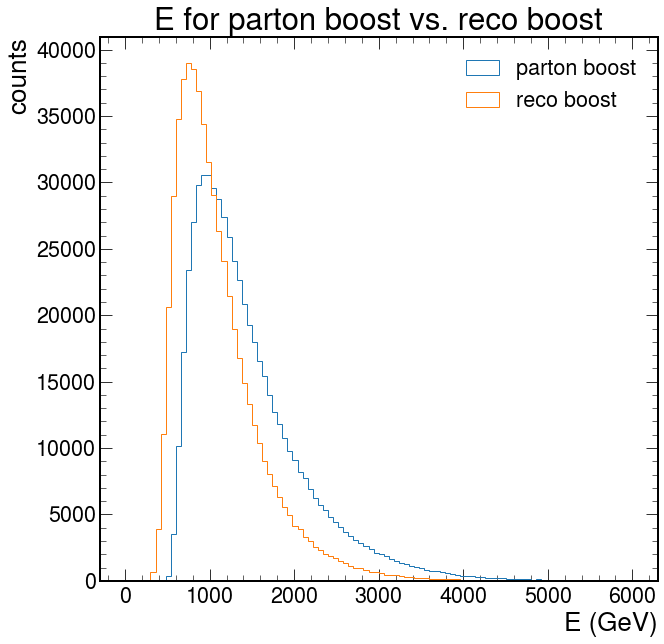

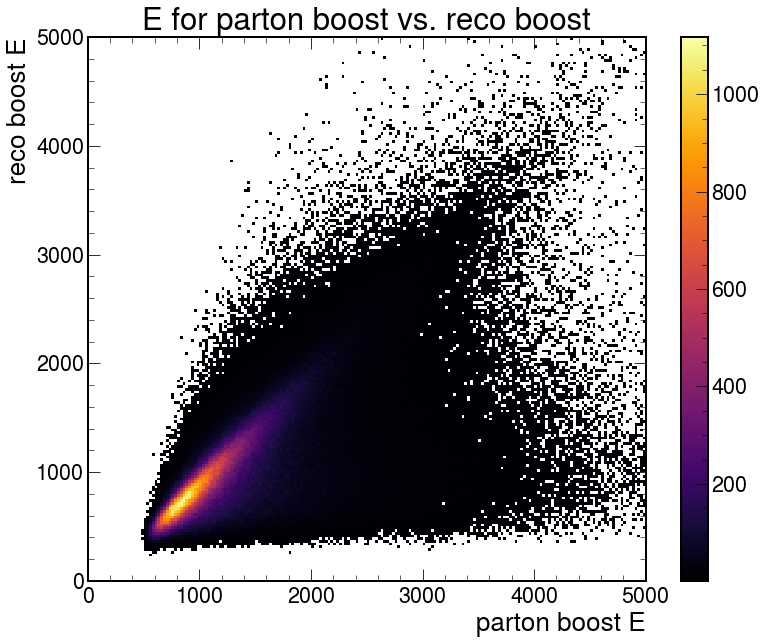

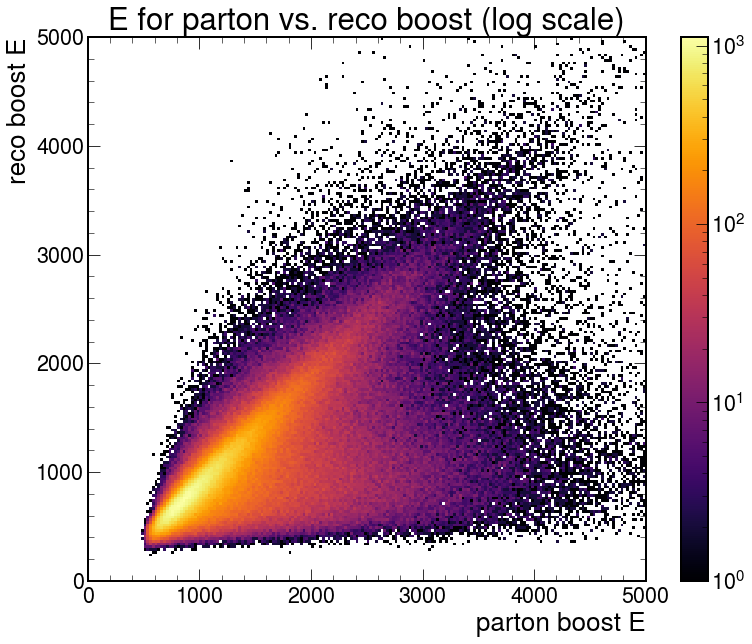

In [89]:
plt.hist(parton_boost.E, bins=100, range=(0, 6000), label="parton boost", histtype="step")
plt.hist(boost_reco.E, bins=100, range=(0, 6000), label="reco boost", histtype="step")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("counts")
plt.title("E for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/E_partonboost_vs_recoboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.E, boost_reco.E, bins=(200,200), range=[[0,5000], [0,5000]], cmap="inferno", cmin=1)
plt.colorbar()
plt.xlabel("parton boost E"); plt.ylabel("reco boost E")
plt.title("E for parton boost vs. reco boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/E_partonboost_vs_recoboost_hist2d")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(parton_boost.E, boost_reco.E, bins=(200,200), range=[[0,5000], [0,5000]], cmap="inferno", cmin=1, norm=LogNorm())
plt.colorbar()
plt.xlabel("parton boost E"); plt.ylabel("reco boost E")
plt.title("E for parton vs. reco boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Parton Boost and Reco Boost/log_E_partonboost_vs_recoboost_hist2d")
plt.show()


# Correlation between initial generator boost and parton boost

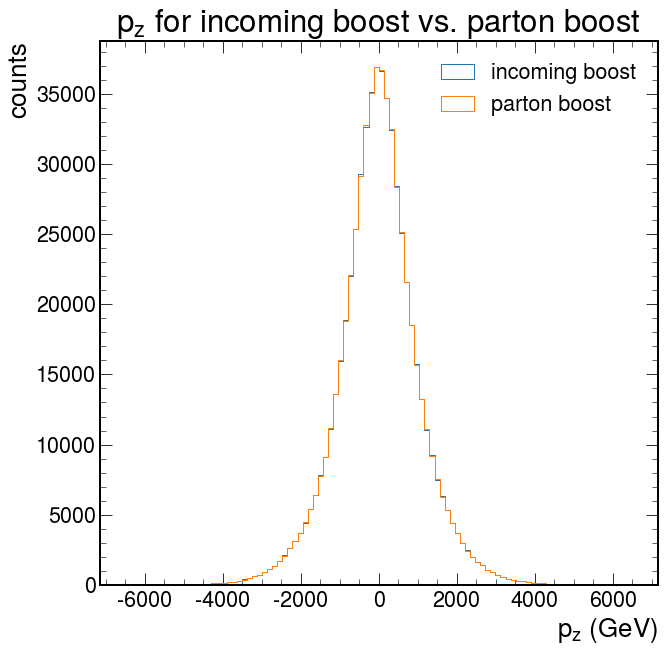

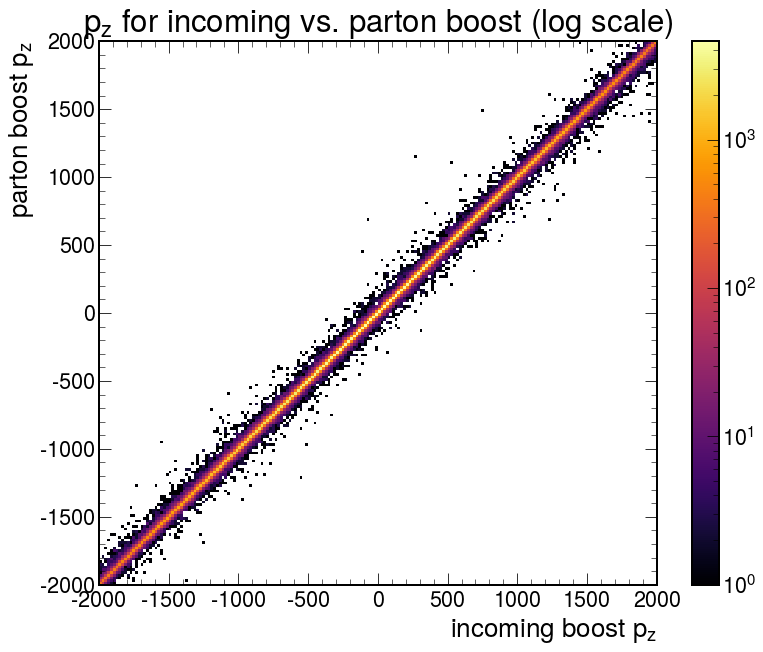

In [90]:
plt.hist(incoming_boost.pz, bins=100, range=(-6500, 6500), label="incoming boost", histtype="step")
plt.hist(parton_boost.pz, bins=100, range=(-6500, 6500), label="parton boost", histtype="step")
plt.legend()
plt.xlabel(r"$p_z$ (GeV)")
plt.ylabel("counts")
plt.title(r"$p_z$ for incoming boost vs. parton boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Parton Boost/pz_incomingboost_vs_partonboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.pz, parton_boost.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", norm=LogNorm())
plt.colorbar()
plt.xlabel("incoming boost $p_z$"); plt.ylabel("parton boost $p_z$")
plt.title(r"$p_z$ for incoming vs. parton boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Parton Boost/log_pz_incomingboost_vs_partonboost_hist2d")
plt.show()

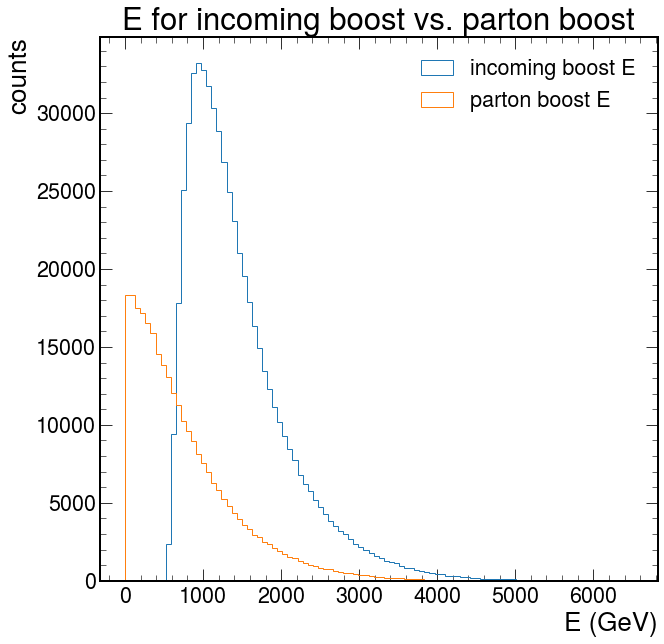

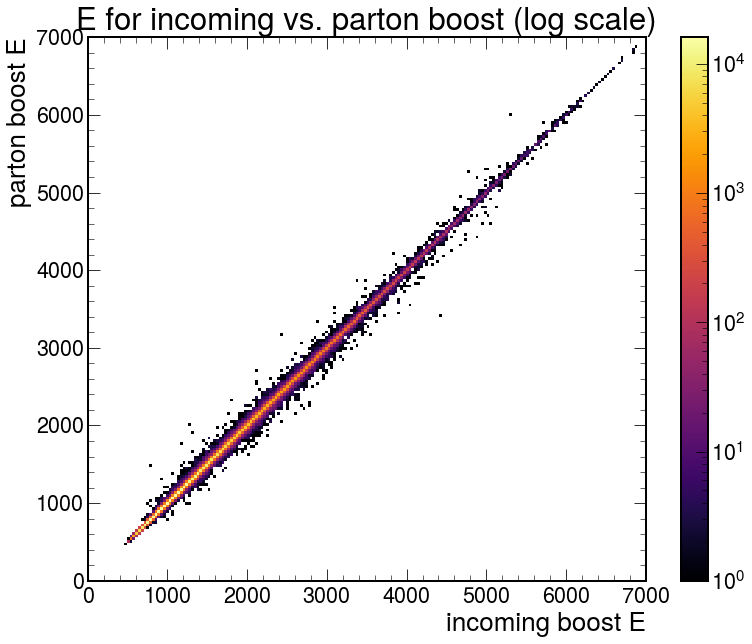

In [91]:
plt.hist(incoming_boost.E, bins=100, range=(0, 6500), label="incoming boost E", histtype="step")
plt.hist(parton_boost.pz, bins=100, range=(0, 6500), label="parton boost E", histtype="step")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("counts")
plt.title("E for incoming boost vs. parton boost")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Parton Boost/E_incomingboost_vs_partonboost")
plt.show()

plt.figure(figsize=(12.5, 10))
plt.hist2d(incoming_boost.E, parton_boost.E, bins=(200,200), range=[[0,7000], [0,7000]], cmap="inferno", norm=LogNorm())
plt.colorbar()
plt.xlabel("incoming boost E"); plt.ylabel("parton boost E")
plt.title("E for incoming vs. parton boost (log scale)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Incoming Boost and Parton Boost/log_E_incomingboost_vs_partonboost_hist2d")
plt.show()

In [92]:
#TODO: Add colorbars, latex format